In [343]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "code"))

import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import patches
from scipy.stats import pearsonr, ttest_rel, ttest_ind

# Modules from this repository
from load_data import (
    load_behavioral_data,
    load_lesion_data
)
from plotting import border, plot_pecking_test_data, color_by_reward, set_oddsratio_yticks
from stats import (
    bootstrap,
    false_discovery,
    fisher_exact,
    get_odds_ratio_matrix,
    jackknife,
    linreg,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Results Section

We trained zebra finches in an operant task to recognize the calls and song of several conspecifics. These vocalizations were presented to the subjects in a go/no-go paradigm as described in {Yu 2020}. In short, subjects were presented with songs or DCs from a set of rewarded vocalizers (Re) and a set of non-rewarded vocalizers (NoRe). In this task, the correct behavioral response to a NoRe stimulus is to interrupt, skipping to the next trial, while the correct response to a Re stimulus is to wait for the food reward to be dispensed. Thus, the relative odds of interrupting Re trials to NoRe trials constitutes the performance on this memory task. In this analysis, we quantify this using the log odds ratio of Re interruption to NoRe interruption, or LogOR (see Methods). LogOR scores significantly greater than 1 indicate that a subject is successfully interrupting NoRe stimuli at a greater rate than Re stimuli, and a score of 1 indicates chance level.

In these experiments, we tested zebra finches on sets of conspecific vocalizations that included either 16 vocalizers by songs (8 Re, 8 NoRe) or 12 vocalizers by DCs (6 Re, 6 NoRe). Each set was learned over the course of a week by gradually increasing the number of vocalizers tested each day: from 1 Re vs 1 NoRe on the first day, to the full set on the last two days (Fig. 2B and 2C). Over the course of an experiment, each subject was (1) trained and tested on one song set and one DC set, (2) lesioned and given up to a week of recovery, (3) re-tested on the same two sets as before, then (4) trained and tested on a second song set and second DC set that they had not heard before (Fig. 2A). The experimental groups included bilateral NCM lesions (n=11), bilateral HVC lesions (n=8), and sham lesion controls (n=3). 

Prior to any operation, all subjects scored significantly above chance on both song and DC stimulus sets (Fig. 3).


In [32]:
trial_data = load_behavioral_data()
lesion_data = load_lesion_data()

#### Define some modifiers that might be used when generating plots later

In [635]:
POTENTIAL_L = ["RedHpi0710F", "WhiBlu5805F"]
PARTIAL_HVC = ["RedGra7912M"]
SET_2_CUT_SHORT = "BluWhi3230M" # Health issues
MICROPHONE_NOT_WORKING_DATE = datetime.date(2020, 11, 20)

HVC_COLOR = "#e6438c"
CTRL_COLOR = "#777777"
NCM_COLOR = "#19b382"
NEUTRAL_COLOR = "#1968c2"

AXIS_SIZE = 14
LABEL_SIZE = 16
MAX_INFORMATIVE_TRIALS = 2

FIGDIR = Path("./figures/svg_originals")
FIGDIR.mkdir(parents=True, exist_ok=True)
def savedir(rel_path):
    """Return the save path relative to FIGDIR"""
    return str(FIGDIR / rel_path)

## Figure 2. Task timeline and description

This figure will show (A) a timeline of the ladder, and (B, C) examples of behavioral performance over the entire ladder (from 1v1 pre-lesion, through post-lesion set 1 and post-lesion set 2), in **2** subjects as the average probability of interruption for each individual stim.

I will select two subjects with relatively clean data, one from the NCM group and one from the HVC group:

* GreWhi2703M (HVC)  TODO: replace this with one of the new subjects for whom we will have better histology / song degredation data for?
* XXXOra0037F (NCM)

These plots will be stitched together in illustrator afterward to align with part (A)

In [350]:
trial_data.Subject.unique()

array(['BluYel2571F', 'GreBlu5039F', 'GreBla3404M', 'GraWhi4040F',
       'BlaGre1349M', 'XXXHpi0038M', 'XXXOra0037F', 'YelPur7906M',
       'WhiWhi2526M', 'XXXBlu0031M', 'HpiGre0651M', 'RedHpi0710F',
       'WhiBlu5805F', 'BluWhi0398F', 'BluWhi3230M', 'GraYel7337F',
       'GreWhi2703M', 'HpiGre8613M', 'BluGre4315M', 'RedGra7912M',
       'BluRed8773M'], dtype=object)

### Define the exact date ranges to plot for our subjects

We'll plot (1) prelesion ladder set 1, (2) postlesion re-test on set 1, (3) postlesion ladder set 2

In [75]:
subject_date_ranges = {
    "XXXOra0037F": (
        (datetime.date(2019, 6, 9), datetime.date(2019, 9, 5)),
        (datetime.date(2019, 9, 6), datetime.date(2019, 9, 15)),
        (datetime.date(2019, 9, 16), datetime.date(2019, 9, 30)),
    ),
    "BluWhi0398F": (
        (datetime.date(2020, 11, 2), datetime.date(2020, 11, 11)),
        (datetime.date(2020, 11, 12), datetime.date(2020, 11, 22)),
        (datetime.date(2020, 11, 23), datetime.date(2021, 12, 30))
    ),
    "BluWhi3230M": (  # MISSING LAST DAY FOR ONE LADDER
        (datetime.date(2020, 11, 2), datetime.date(2020, 11, 11)),
        (datetime.date(2020, 11, 12), datetime.date(2020, 11, 22)),
        (datetime.date(2020, 11, 23), datetime.date(2021, 12, 30))
    ),
    "GraYel7337F": (
        (datetime.date(2020, 11, 2), datetime.date(2020, 11, 11)),
        (datetime.date(2020, 11, 12), datetime.date(2020, 11, 22)),
        (datetime.date(2020, 11, 23), datetime.date(2021, 12, 30))
    ),
    "GreWhi2703M": (
        (datetime.date(2020, 11, 2), datetime.date(2020, 11, 11)),
        (datetime.date(2020, 11, 12), datetime.date(2020, 11, 22)),
        (datetime.date(2020, 11, 23), datetime.date(2021, 12, 30))
    ),
} 

Preview the what data will be plotted given the subject and set

In [81]:
for (l, d), subdf in trial_data[
            (trial_data["Subject"] == "BluWhi3230M") &
            (trial_data["Ladder Group"] == "PostlesionSet2")
        ].groupby(["Test Context", "Date"]):
    print(l, "from", subdf.Date.iloc[0], subdf.Date.iloc[-1])
    for j, _ in subdf.groupby(["Stimulus Vocalizer", "Stimulus Class"]):
          print("\t", j)

DCvsDC_1v1_S2 from 2020-11-30 2020-11-30
	 ('BlaBla0506', 'Rewarded')
	 ('LblRed0613', 'Nonrewarded')
DCvsDC_4v4_S2 from 2020-12-01 2020-12-01
	 ('BlaBla0506', 'Rewarded')
	 ('LblRed0613', 'Nonrewarded')
	 ('PurRas20dd', 'Rewarded')
	 ('Unknown00F', 'Nonrewarded')
	 ('WhiBlu4818', 'Rewarded')
	 ('WhiRas44dd', 'Nonrewarded')
	 ('WhiWhi1415', 'Rewarded')
	 ('YelGre5275', 'Nonrewarded')
DCvsDC_6v6_d1_S2 from 2020-12-02 2020-12-02
	 ('BlaBla0506', 'Rewarded')
	 ('BluRas61dd', 'Rewarded')
	 ('GreGre6364', 'Rewarded')
	 ('LblRed0613', 'Nonrewarded')
	 ('PurRas20dd', 'Rewarded')
	 ('Unknown00F', 'Nonrewarded')
	 ('WhiBlu4818', 'Rewarded')
	 ('WhiGra0114', 'Nonrewarded')
	 ('WhiLbl0010', 'Nonrewarded')
	 ('WhiRas44dd', 'Nonrewarded')
	 ('WhiWhi1415', 'Rewarded')
	 ('YelGre5275', 'Nonrewarded')
DCvsDC_6v6_d2_S2 from 2020-12-03 2020-12-03
	 ('LblRed0613', 'Nonrewarded')
	 ('Unknown00F', 'Nonrewarded')
	 ('WhiGra0114', 'Nonrewarded')
	 ('WhiLbl0010', 'Nonrewarded')
	 ('WhiRas44dd', 'Nonrewarded')

In [355]:
def trials_plot_for_subject(subject):
    subject_df = trial_data[trial_data["Subject"] == subject]
    
    # This is a specific date where the stimuli were played to the wrong subject. 
    subject_df = subject_df[subject_df["Date"] != MICROPHONE_NOT_WORKING_DATE]

    if subject not in subject_date_ranges:
        raise Exception("Define the subject date ranges. Dates are from {} to {}".format(
            np.min(subject_df.Date.unique()),
            np.max(subject_df.Date.unique())
        ))
        
    prelesion_date_range, postlesion_date_range, postlesion_new_date_range = subject_date_ranges[subject]

    # Prelesion Plot
    date_df = subject_df[
        (subject_df.Date >= prelesion_date_range[0]) &
        (subject_df.Date <= prelesion_date_range[1])
    ]
    fig = plot_pecking_test_data(
        date_df,
        ["Stimulus Class", "Stimulus Vocalizer", "Stimulus Call Type"],
        ticks=False,
        figsize=(6, 3),
        linekwargs={"linewidth": 0.5},
        mark_days=True
    )
    fig.savefig(savedir("trials_A_prelesion_{}.svg".format(subject)), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)

    # Postlesion recall
    date_df = subject_df[
        (subject_df.Date >= postlesion_date_range[0]) &
        (subject_df.Date <= postlesion_date_range[1])
    ]

    fig = plot_pecking_test_data(
        date_df,
        ["Stimulus Class", "Stimulus Vocalizer", "Stimulus Call Type"],
        ticks=False,
        figsize=(4, 3),
        linekwargs={"linewidth": 0.5},
        mark_days=True
    )
    fig.savefig(savedir("trials_B_postlesion_{}.svg".format(subject)), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)

    # Postlesion learning
    date_df = subject_df[
        (subject_df.Date >= postlesion_new_date_range[0]) &
        (subject_df.Date <= postlesion_new_date_range[1])
    ]

    fig = plot_pecking_test_data(
        date_df,
        ["Stimulus Class", "Stimulus Vocalizer", "Stimulus Call Type"],
        ticks=False,
        figsize=(6, 3),
        linekwargs={"linewidth": 0.5},
        mark_days=True
    )
    fig.savefig(savedir("trials_C_postlesion_new_{}.svg".format(subject)), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)

2019-09-05


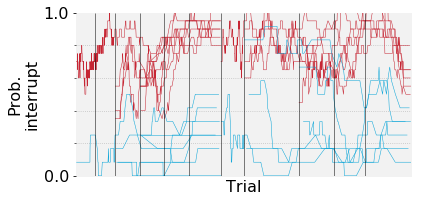

2019-09-15


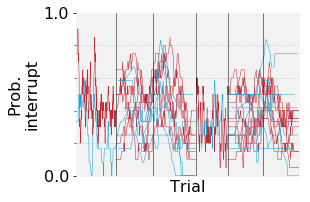

2019-09-27


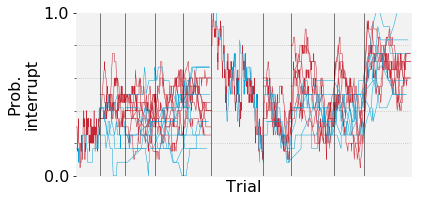

In [356]:
trials_plot_for_subject("XXXOra0037F")

2020-11-11


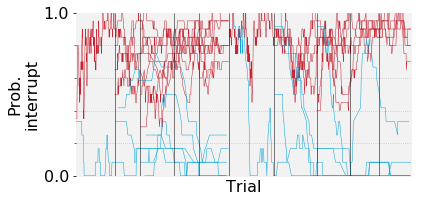

2020-11-22


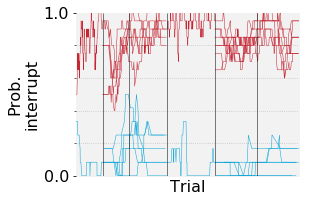

2020-12-04


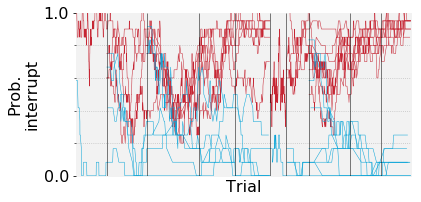

In [357]:
trials_plot_for_subject("GreWhi2703M")

## Figure 3. Before and after lesion on the same set (recall)

To illustrate this data, we will compare the performance of each subject in a time period before and after trial.

(1) Compare the overall performance during the last two days of each period. This is a little rough because subjects would have the entire span of time to re-learn the vocalizers even if lesions damaged their memory

(2) Compare the performance on only the early (first 3) informative trials. This would be early on enough that, if memory was damaged by lesion, they would not have learned fast enough to relearn. We would include all trials up to (and not including) the **3rd informative trial** of each vocalizer after lesion (this would mostly include early on the 8v8_d2 or 6v6_d2 days, but for the first stim include early on the 1v1 day). The comparison period pre-lesion should be the first informative trials on the last day of 8v8_d2 or 6v6_d2 **although for simplicity we will use the first day of 8v8_d2/6v6_d2**

To do this, we will generate a table with the performance during each period of interest. For each subject, phase (PrelesionSet1, PostlesionSet1, PostlesionSet2), call type (So/DC), and mode (all, 3 informative trials), we will calculate the odds ratio, confidence interval, log odds ratio, and p value

In [499]:
def inject_relative_informative_trials(df):
    """Takes a dataframe with a subset of trials and injects a column of "Relative Informative Trials Seen"
    which indicates the number of informative trials seen by a subject for a given vocalizer in the
    selected range
    """
    df = df.copy()
    df["Relative Informative Trials Seen"] = df["Informative Trials Seen"]
    for (subj, vocalizer, call_type), subdf in df.groupby(["Subject", "Stimulus Vocalizer", "Stimulus Call Type"]):
        df.loc[
            subdf.index,
            "Relative Informative Trials Seen"
        ] -= subdf.iloc[0]["Informative Trials Seen"]
    
    return df

def generate_informative_trial_dataframe(df, informative_trials):
    """Generate a dataframe with interruption data per bin per subject PER STIMULUS
    from the selected trials
    """
    # The "Informative Trials Seen" column counts informative trials seen for a given stim across
    # all sessions run for a subject. The given dataframe may only include trials from a selected
    # epoch which may not include the first sessions. So we create a new "Relative Informative Trials Seen"
    # column that shows number of informative trials seen relative to the start of the requested range.
    df = inject_relative_informative_trials(df)
    output_rows = []
    for bin_idx in informative_trials:
        bin_df = df[df["Relative Informative Trials Seen"] == bin_idx]
        for (subject, subject_sex, vocalizer, call_type, rewarded), stim_df in bin_df.groupby([
                    "Subject", "Subject Sex", "Stimulus Vocalizer", "Stimulus Call Type", "Stimulus Class"
                ]):
            output_rows.append([
                subject,
                subject_sex,
                vocalizer,
                call_type,
                rewarded,
                bin_idx,
                len(stim_df),
                np.mean(stim_df["Interrupt"])  # This should be just 1 / len(stim_df)
            ])
            
    return pd.DataFrame(output_rows, columns=["Subject", "Subject Sex", "Stimulus Vocalizer", "Stimulus Call Type",
            "Stimulus Class", "Relative Informative Trials Seen", "Bin Size", "p(interrupt)"])

def process_first_n_informative_trials(df, n=2):
    """Assess interruption rates and odds ratio in first n informative trials (inclusive)
    """
    inform_df = generate_informative_trial_dataframe(df, np.arange(n))
    # The following line ensures that we bin 0&1 into bin 0, 2&3 into bin 2, etc
    subdf = inform_df[inform_df["Relative Informative Trials Seen"] <= n]
    re = subdf[subdf["Stimulus Class"] == "Rewarded"]
    nore = subdf[subdf["Stimulus Class"] == "Nonrewarded"]
    
    
    # THIS DOESNT USE fisher_exact AS WE ARE COMPUTING THIS PER VOCALIZER!
    # Otherwise, if using per trial, stimuli with high interruption rates get overweighted
    # as they natrually have more interruptions
    # This doesn't affect the full day since we are actually looking at all trials presented
    # in an unbiased way - no matter the interruption rate, each stim is still represented at
    # a fair proportion. it only affects the "first n informative trial" analysis since
    # we are artifically limiting our data to the first n informative trials per stimulus which 
    # can be different per stimulus. 
    if not len(re):
        raise ValueError("No rewarded stimuli found")
    if not len(nore):
        raise ValueError("No nonrewarded stimuli found")

    if len(re) != len(nore):
        raise Exception("Different number of rewarded stimuli than nonrewarded")

    p_re, sem_re = jackknife(re["p(interrupt)"], np.mean)
    p_nore, sem_nore = jackknife(nore["p(interrupt)"], np.mean)

    if p_re == 0:
        p_re = 0.5 / len(re["p(interrupt)"])

    if p_nore == 0:
        p_nore = 0.5 / len(nore["p(interrupt)"])

    def _logor(p_re, p_nore):
        p_re = np.mean(p_re)
        p_nore = np.mean(p_nore)

        if p_re == 0:
            p_re = 0.5 / len(re["p(interrupt)"])

        if p_nore == 0:
            p_nore = 0.5 / len(nore["p(interrupt)"])

        return np.log2(p_nore / (1 - p_nore)) - np.log2(p_re / (1 - p_re))
    
    def _or(p_re, p_nore):
        p_re = np.mean(p_re)
        p_nore = np.mean(p_nore)

        if p_re == 0:
            p_re = 0.5 / len(re["p(interrupt)"])

        if p_nore == 0:
            p_nore = 0.5 / len(nore["p(interrupt)"])
        
        return p_nore * (1 - p_re) / (p_re * (1 - p_nore))

    logor = _logor(re["p(interrupt)"], nore["p(interrupt)"])
    logor_sem = bootstrap(_logor, re["p(interrupt)"], nore["p(interrupt)"])
    
    return {
        "p_re": p_re,
        "p_nore": p_nore,
        "sem_re": sem_re,
        "sem_nore": sem_nore,
        "odds_ratio": _or(re["p(interrupt)"], nore["p(interrupt)"]),
        "logor": logor,
        "logor_sem": logor_sem
    }

### First, summarize overall performance as an odds ratio

This code taken nearly verbatim from https://github.com/theunissenlab/zebra-finch-memory

It takes all the trials from full ladder (SovsSo_8v8_d2 or DCvsDC_6v6_d2) from before lesion (PrelesionSet1) and after lesion (PostlesionSet1). On these days, all the stimuli were played at equal rates and the birds had at least one day of experience with every stimulus.

The last two rows compute the scores of the full ladder of the second set of stimuli, which were only presented after lesion (SovsSo_8v8_d2_S2 and DCvsDC_6v6_d2_S2, PostlesionSet2).

The performance will also be calculated on trials prior to the third informative trial. This will be calculated in 5 time-frames:

* Early prelesion set 1
* Late prelesion set 1
* Early postlesion set 1
* Early postlesion set 2
* Late postlesion set 2

The most relevant comparisons we will be making are  Late prelesion set 1 vs Early postlesion set 1, and Early prelesion set 1 vs early postlesion set 2, although the latter (and perhaps both) would be better served with learning curve plots

In [500]:
MODES = {
    "EARLY_PRELESION_SET_1": [("PrelesionSet1", "SO", None), ("PrelesionSet1", "DC", None)],
    "LATE_PRELESION_SET_1": [("PrelesionSet1", "SO", "SovsSo_8v8_d2"), ("PrelesionSet1", "DC", "DCvsDC_6v6_d2")],
    "EARLY_POSTLESION_SET_1": [("PostlesionSet1", "SO", None), ("PostlesionSet1", "DC", None)],
    "EARLY_POSTLESION_SET_2": [("PostlesionSet2", "SO", None), ("PostlesionSet2", "DC", None)],
    "LATE_POSTLESION_SET_2": [("PostlesionSet2", "SO", "SovsSo_8v8_d2_S2"), ("PostlesionSet2", "DC", "DCvsDC_6v6_d2_S2")],
}

performance_df_rows = []
for subject in lesion_data["Subject"]:
    subject_df = trial_data[
        (trial_data["Subject"] == subject)
    ]
    subj_group = subject_df.iloc[0]["Treatment"]
    for ctx, condition in [
                ("SovsSo_8v8_d2", "PrelesionSet1"),
                ("DCvsDC_6v6_d2", "PrelesionSet1"),
                ("SovsSo_8v8_d2", "PostlesionSet1"),
                ("DCvsDC_6v6_d2", "PostlesionSet1"),
                ("SovsSo_8v8_d2_S2", "PostlesionSet2"),
                ("DCvsDC_6v6_d2_S2", "PostlesionSet2"),
            ]:
        ctx_df = subject_df[(subject_df["Test Context"] == ctx) & (subject_df["Ladder Group"] == condition)]

        rewarded_set = ctx_df[ctx_df["Stimulus Class"] == "Rewarded"]
        nonrewarded_set = ctx_df[ctx_df["Stimulus Class"] == "Nonrewarded"]

        table = get_odds_ratio_matrix(nonrewarded_set, rewarded_set, "Interrupt")
        odds, interval95, p_value = fisher_exact(table, side="greater")
        se_logor = np.sqrt(
            np.sum(1 / table)
        )

        performance_df_rows.append(
            [
                subject, subj_group, ctx, condition,
                odds, interval95[0], interval95[1],
                np.log(odds), se_logor, p_value,
                ctx[:2].upper(), "OVERALL"
            ]
        )
        
    # Make rows for each condition in MODES
#     for mode in MODES:
    for mode, mode_values in MODES.items():
        for (ladder_group, call_type, test_context) in mode_values:
            if subject == SET_2_CUT_SHORT and test_context == "DCvsDC_6v6_d2_S2":
                continue
            mode_df = subject_df[
                (subject_df["Ladder Group"] == ladder_group) &
                (subject_df["Stimulus Call Type"] == call_type)
            ]
            if test_context is not None:
                mode_df = mode_df[mode_df["Test Context"] == test_context]

            processed_data = process_first_n_informative_trials(mode_df, MAX_INFORMATIVE_TRIALS)

            performance_df_rows.append([
                subject, subj_group, test_context, ladder_group,
                processed_data["odds_ratio"], None, None,
                processed_data["logor"], processed_data["logor_sem"], None,
                call_type, mode,
            ])


performance_df = pd.DataFrame(
    performance_df_rows,
    columns=["Subject", "Treatment", "Test Context", "Ladder Group",
             "Odds Ratio", "95 CI Lower", "95 CI Upper",
             "LogOR", "SE(LogOR)", "p-value",
             "Call Type", "Mode"
            ]
)

/auto/fhome/kevin/Projects/pecking_analysis/env/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


In [501]:
performance_df

,Subject,Treatment,Test Context,Ladder Group,Odds Ratio,95 CI Lower,95 CI Upper,LogOR,SE(LogOR),p-value,Call Type,Mode
0,GraWhi4040F,NCM,SovsSo_8v8_d2,PrelesionSet1,8.372638,5.463430,inf,2.124969,0.262190,6.881266e-22,SO,OVERALL
1,GraWhi4040F,NCM,DCvsDC_6v6_d2,PrelesionSet1,9.140584,6.613899,inf,2.212724,0.197570,2.516210e-35,DC,OVERALL
2,GraWhi4040F,NCM,SovsSo_8v8_d2,PostlesionSet1,2.474424,1.873942,inf,0.906008,0.169541,1.377995e-08,SO,OVERALL
3,GraWhi4040F,NCM,DCvsDC_6v6_d2,PostlesionSet1,2.979033,2.274227,inf,1.091599,0.164532,5.639628e-12,DC,OVERALL
4,GraWhi4040F,NCM,SovsSo_8v8_d2_S2,PostlesionSet2,4.369207,3.162899,inf,1.474581,0.197195,2.683568e-15,SO,OVERALL
5,GraWhi4040F,NCM,DCvsDC_6v6_d2_S2,PostlesionSet2,3.950162,3.016068,inf,1.373757,0.164403,1.222543e-17,DC,OVERALL
6,GraWhi4040F,NCM,SovsSo_8v8_d2_S2,PostlesionSet2,2.987368,NaN,NaN,1.578875,1.105940,NaN,SO,LATE_POSTLESION_SET_2
7,GraWhi4040F,NCM,DCvsDC_6v6_d2_S2,PostlesionSet2,4.834497,NaN,NaN,2.273366,1.228599,NaN,DC,LATE_POSTLESION_SET_2
8,GraWhi4040F,NCM,None,PostlesionSet1,0.698824,NaN,NaN,-0.517000,1.167910,NaN,SO,EARLY_POSTLESION_SET_1
9,GraWhi4040F,NCM,None,PostlesionSet1,0.858217,NaN,NaN,-0.220586,1.042123,NaN,DC,EARLY_POSTLESION_SET_1


In [502]:
hvc_df = performance_df[performance_df["Treatment"] == "HVC"]
ctrl_df = performance_df[performance_df["Treatment"] == "CTRL"]
ncm_df = performance_df[performance_df["Treatment"] == "NCM"]

### Test figure

Lets make a test figure that shows the progression of each subject from EARLY_PRELESION_SET_1 to LATE_PRELESION_SET_1 to EARLY_POSTLESION_SET_1

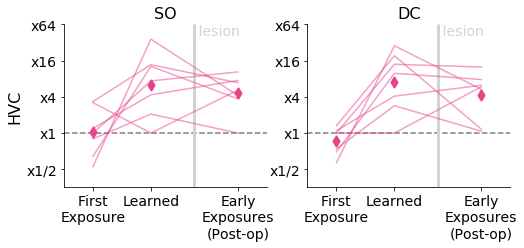

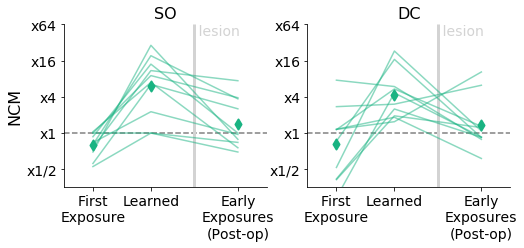

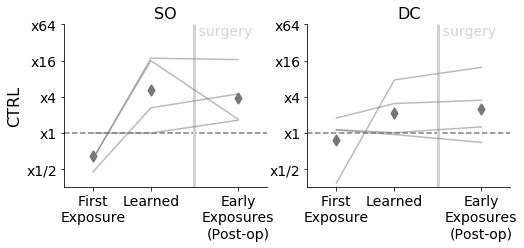

In [503]:
def summary(group_df, name, color):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    for ax_i, call_type in enumerate(["SO", "DC"]):
        call_type_data = group_df[
            (group_df["Call Type"] == call_type)
        ]
        for subject in group_df.Subject.unique():
            subj_data = call_type_data[call_type_data["Subject"] == subject]
            axes[ax_i].plot(
                [0, 1, 2.5],
                [
                subj_data[subj_data["Mode"] == "EARLY_PRELESION_SET_1"].iloc[0]["LogOR"],
                subj_data[subj_data["Mode"] == "LATE_PRELESION_SET_1"].iloc[0]["LogOR"],
                subj_data[subj_data["Mode"] == "EARLY_POSTLESION_SET_1"].iloc[0]["LogOR"],
            ], alpha=0.5, color=color)
        
        axes[ax_i].scatter([0, 1, 2.5], [
            np.mean(call_type_data[call_type_data["Mode"] == "EARLY_PRELESION_SET_1"]["LogOR"]),
            np.mean(call_type_data[call_type_data["Mode"] == "LATE_PRELESION_SET_1"]["LogOR"]),
            np.mean(call_type_data[call_type_data["Mode"] == "EARLY_POSTLESION_SET_1"]["LogOR"]),
        ], marker="d", linewidth=2, s=50, color=color)
        
        
        axes[ax_i].set_xlim(-0.5, 3)
        border(axes[ax_i], 1, 0, 0, 1)
        axes[ax_i].set_yticks([-2, 0, 2, 4, 6])
        axes[ax_i].set_yticklabels(["x1/2", "x1", "x4", "x16", "x64"], fontsize=AXIS_SIZE)
        axes[ax_i].hlines([0], -0.5, 3, linestyle="--", color="Grey", zorder=-1)
        axes[ax_i].set_ylim(-3, 6)
        axes[ax_i].set_xticks([0, 1, 2.5])
        axes[ax_i].set_xticklabels(["First\nExposure", "Learned", "Early\nExposures\n(Post-op)"], fontsize=AXIS_SIZE)
        
        axes[ax_i].vlines([1.75], *axes[ax_i].get_ylim(), color="LightGrey", linewidth=3, zorder=-1)
        axes[ax_i].text(1.75, 6, " lesion" if name != "CTRL" else " surgery", fontsize=AXIS_SIZE, verticalalignment="top", color="LightGrey")
            
        axes[ax_i].set_title(call_type, fontsize=LABEL_SIZE)
    
    axes[0].set_ylabel(name, fontsize=LABEL_SIZE)
    
    fig.savefig(savedir("recall_comparisons_3InTr_A_{}.svg".format(name)), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)
    
summary(hvc_df, "HVC", color=HVC_COLOR)
summary(ncm_df, "NCM", color=NCM_COLOR)
summary(ctrl_df, "CTRL", color=CTRL_COLOR)

In [504]:
print("Our dataset has {} HVC, {} CTRL, and {} NCM subjects".format(
    len(np.unique(hvc_df.Subject)),
    len(np.unique(ctrl_df.Subject)),
    len(np.unique(ncm_df.Subject))
))

Our dataset has 7 HVC, 4 CTRL, and 10 NCM subjects


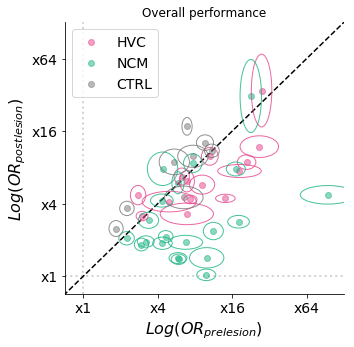

In [509]:
def summary_2(group_df, name, color):
    ax = plt.gca()
    for ax_i, call_type in enumerate(["SO", "DC"]):
        if call_type == "SO":
            call_type_data = group_df[group_df["Test Context"] == "SovsSo_8v8_d2"]
        else:
            call_type_data = group_df[group_df["Test Context"] == "DCvsDC_6v6_d2"]

        for i, subject in enumerate(group_df.Subject.unique()):
            subj_data = call_type_data[call_type_data["Subject"] == subject]
            
            prelesion_set_1 = subj_data[
                (subj_data["Ladder Group"] == "PrelesionSet1")
            ]
            postlesion_set_1 = subj_data[
                (subj_data["Ladder Group"] == "PostlesionSet1")
            ]
                
            or1 = prelesion_set_1.iloc[0]["LogOR"]
            or2 = postlesion_set_1.iloc[0]["LogOR"]
            err1 = prelesion_set_1.iloc[0]["SE(LogOR)"]
            err2 = postlesion_set_1.iloc[0]["SE(LogOR)"]
            
            ax.scatter(
                [or1],
                [or2],
                alpha=0.5,
                color=color,
                label=name if i == ax_i == 0 else None
            )
            
            if err1 > 100000000:
                err1 = np.mean(group_df[group_df["SE(LogOR)"] < 100000000]["SE(LogOR)"])
                        
            e1 = patches.Ellipse(
                (or1, or2),
                2 * err1,
                2 * err2,
                angle=0, linewidth=1, fill=None, alpha=0.8, color=color, zorder=2)
            ax.add_patch(e1)

fig = plt.figure(figsize=(5, 5))
summary_2(hvc_df, "HVC", color=HVC_COLOR)
summary_2(ncm_df, "NCM", color=NCM_COLOR)
summary_2(ctrl_df, "CTRL", color=CTRL_COLOR)

plt.legend(fontsize=AXIS_SIZE)
plt.xlim(-0.5, 7)
plt.ylim(-0.5, 7)
# plt.xscale("log")
# plt.yscale("log")
plt.xticks([0, 2, 4, 6], [
    "x1", "x4", "x16", "x64"
], fontsize=AXIS_SIZE)
plt.yticks([0, 2, 4, 6], [
    "x1", "x4", "x16", "x64"
], fontsize=AXIS_SIZE)

plt.xlabel(r"$Log(OR_{prelesion})$", fontsize=LABEL_SIZE)
plt.ylabel(r"$Log(OR_{postlesion})$", fontsize=LABEL_SIZE)

plt.title("Overall performance")

border(plt.gca(), 1, 0, 0, 1)
plt.plot([-1, 10], [-1, 10], color="Black", linestyle="--", zorder=-1)
plt.vlines([0], *plt.ylim(), color="LightGrey", linestyle=":", linewidth=2, zorder=-1)
plt.hlines([0], *plt.xlim(), color="LightGrey", linestyle=":", linewidth=2, zorder=-1)

fig.savefig(savedir("pre_post_scatter_overall.svg"), format="svg", bbox_inches="tight")
plt.show()
plt.close(plt.gcf())

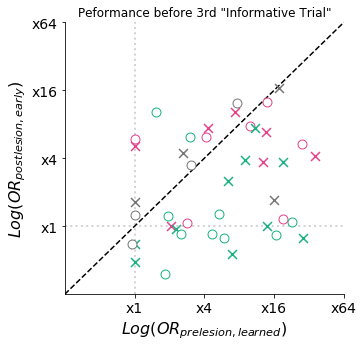

In [674]:
def summary_3(group_df, name, color):
    ax = plt.gca()
    for ax_i, call_type in enumerate(["SO", "DC"]):
        call_type_data = group_df[
            (group_df["Call Type"] == call_type)
        ]
        for subject in group_df.Subject.unique():
            subj_data = call_type_data[call_type_data["Subject"] == subject]
            
            prelesion_set_1 = subj_data[subj_data["Mode"] == "LATE_PRELESION_SET_1"]
            or1 = prelesion_set_1.iloc[0]["LogOR"]
            postlesion_set_1 = subj_data[subj_data["Mode"] == "EARLY_POSTLESION_SET_1"]
            or2 = postlesion_set_1.iloc[0]["LogOR"]
            err1 = prelesion_set_1.iloc[0]["SE(LogOR)"]
            err2 = postlesion_set_1.iloc[0]["SE(LogOR)"]
            
            ax.scatter(
                [or1],
                [or2],
                alpha=1.0,
                marker="o" if call_type == "DC" else "x",
                s=80,
                facecolor="White" if call_type == "DC" else color,
                color=color,
            )
                        
#             e1 = patches.Ellipse(
#                 (or1, or2),
#                 err1,
#                 err2,
#                 angle=0, linewidth=1, fill=None, alpha=0.8, color=color, zorder=2)
#             ax.add_patch(e1)

fig = plt.figure(figsize=(5, 5))
summary_3(hvc_df, "HVC", color=HVC_COLOR)
summary_3(ncm_df, "NCM", color=NCM_COLOR)
summary_3(ctrl_df, "CTRL", color=CTRL_COLOR)

# plt.legend(fontsize=AXIS_SIZE)
plt.xlim(-2, 5)
plt.ylim(-2, 5)
# plt.xscale("log")
# plt.yscale("log")
plt.xticks([0, 2, 4, 6], [
    "x1", "x4", "x16", "x64"
], fontsize=AXIS_SIZE)
plt.yticks([0, 2, 4, 6], [
    "x1", "x4", "x16", "x64"
], fontsize=AXIS_SIZE)

plt.xlabel(r"$Log(OR_{prelesion,learned})$", fontsize=LABEL_SIZE)
plt.ylabel(r"$Log(OR_{postlesion,early})$", fontsize=LABEL_SIZE)

plt.title("Peformance before 3rd \"Informative Trial\"")

border(plt.gca(), 1, 0, 0, 1)
plt.plot([-2, 10], [-2, 10], color="Black", linestyle="--", zorder=-1)
plt.vlines([0], *plt.ylim(), color="LightGrey", linestyle=":", linewidth=2, zorder=-1)
plt.hlines([0], *plt.xlim(), color="LightGrey", linestyle=":", linewidth=2, zorder=-1)

fig.savefig(savedir("pre_post_scatter_3InTr.svg"), format="svg", bbox_inches="tight")

plt.show()
plt.close(plt.gcf())

### Per logans suggestion

We can project this data into one dimension by computing histograms of distance to the x=y line, or in other words projecting the points onto the x=-y line.

In [650]:
def projection(x, y):
    """Convert an x, y coordinate into a scalar distance from the x=y line (y > x is positive)"""
    d = np.sqrt(2) * (y - x)
    return d

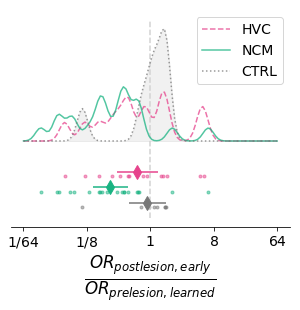

In [797]:
from sklearn.neighbors import KernelDensity


def summary_4(group_df, name, color, linestyle):
    ax = plt.gca()
    pts = []
    for ax_i, call_type in enumerate(["SO", "DC"]):
        call_type_data = group_df[
            (group_df["Call Type"] == call_type)
        ]
        for subject in group_df.Subject.unique():
            subj_data = call_type_data[call_type_data["Subject"] == subject]
            
            prelesion_set_1 = subj_data[subj_data["Mode"] == "LATE_PRELESION_SET_1"]
            or1 = prelesion_set_1.iloc[0]["LogOR"]
            postlesion_set_1 = subj_data[subj_data["Mode"] == "EARLY_POSTLESION_SET_1"]
            or2 = postlesion_set_1.iloc[0]["LogOR"]
            err1 = prelesion_set_1.iloc[0]["SE(LogOR)"]
            err2 = postlesion_set_1.iloc[0]["SE(LogOR)"]
            pts.append(or2 - or1)
    
    pts = np.array(pts)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(pts)
    x = np.linspace(-6, 6, 100)
    ax.plot(x, np.exp(kde.score_samples(x[:, np.newaxis])), color=color, linestyle=linestyle, alpha=0.75, label="{}".format(name))
    if name == "CTRL":
        ax.fill_between(x, 0, np.exp(kde.score_samples(x[:, np.newaxis])), color=color, alpha=0.1, zorder=-1)
    return pts, 2 * np.std(pts) / np.sqrt(len(pts))
    
#     ax.hist(pts, alpha=0.5, linestyle="-", color=color, histtype="step", range=(-6, 4), bins=10)
            
#             ax.scatter(
#                 [or1],
#                 [or2],
#                 alpha=0.5,
#                 color=color,
#             )
                        
#             e1 = patches.Ellipse(
#                 (or1, or2),
#                 err1,
#                 err2,
#                 angle=0, linewidth=1, fill=None, alpha=0.8, color=color, zorder=2)
#             ax.add_patch(e1)

fig = plt.figure(figsize=(5, 4))
# plt.subplot(3, 1, 1)
# border(plt.gca(), 0, 0, 0, 1)
mean_hvc, se_hvc = summary_4(hvc_df, "HVC", color=HVC_COLOR, linestyle="--")
# plt.vlines([0], *plt.ylim(), color="LightGrey", zorder=-1, linestyle="--")

# plt.subplot(3, 1, 2)
# border(plt.gca(), 0, 0, 0, 1)
mean_ncm, se_ncm = summary_4(ncm_df, "NCM", color=NCM_COLOR, linestyle="-")
# plt.vlines([0], *plt.ylim(), color="LightGrey", zorder=-1, linestyle="--")

# plt.subplot(3, 1, 3)
mean_ctrl, se_ctrl = summary_4(ctrl_df, "CTRL", color=CTRL_COLOR, linestyle=":")

dy = (plt.ylim()[1] - plt.ylim()[0]) / 8
plt.scatter(mean_hvc, [-2.3 * dy] * len(mean_hvc), marker=".", color=HVC_COLOR, zorder=-1, alpha=0.5)
plt.errorbar(np.mean(mean_hvc), -2 * dy, xerr=se_hvc, color=HVC_COLOR, marker="d", markersize=10)
plt.scatter(mean_ncm, [-3.3 * dy] * len(mean_ncm), marker=".", color=NCM_COLOR, zorder=-1, alpha=0.5)

plt.errorbar(np.mean(mean_ncm), -3 * dy, xerr=se_ncm, color=NCM_COLOR, marker="d", markersize=10)
plt.scatter(mean_ctrl, [-4.3 * dy] * len(mean_ctrl), marker=".", color=CTRL_COLOR, zorder=-1, alpha=0.5)

plt.errorbar(np.mean(mean_ctrl), -4 * dy, xerr=se_ctrl, color=CTRL_COLOR, marker="d", markersize=10)



plt.vlines([0], *plt.ylim(), color="LightGrey", zorder=-1, linestyle="--")
border(plt.gca(), 0, 0, 0, 1)
plt.xticks([-6, -3, 0, 3, 6], [r"$1/64$", r"$1/8$", r"$1$", r"$8$", "$64$"], fontsize=AXIS_SIZE)
plt.yticks([])
# plt.hlines([0], *plt.xlim(), color="#888888", zorder=-10, alpha=0.5, linestyle="-")


plt.legend(fontsize=AXIS_SIZE)
plt.xlabel(r"$\frac{OR_{postlesion,early}}{OR_{prelesion,learned}}$", fontsize=1.5 * LABEL_SIZE)

fig.savefig(savedir("pre_post_1D_projected_3InTr.svg"), format="svg", bbox_inches="tight")

# plt.xlim(-2, 5)
# plt.ylim(-2, 5)
# # plt.xscale("log")
# # plt.yscale("log")
# plt.xticks([0, 2, 4, 6], [
#     "x1", "x4", "x16", "x64"
# ], fontsize=AXIS_SIZE)
# plt.yticks([0, 2, 4, 6], [
#     "x1", "x4", "x16", "x64"
# ], fontsize=AXIS_SIZE)

# plt.xlabel(r"$Log(OR_{prelesion,learned})$", fontsize=LABEL_SIZE)
# plt.ylabel(r"$Log(OR_{postlesion,early})$", fontsize=LABEL_SIZE)

# plt.title("Peformance before 3rd \"Informative Trial\"")

# border(plt.gca(), 1, 0, 0, 1)
# plt.plot([-2, 10], [-2, 10], color="Black", linestyle="--", zorder=-1)
# plt.vlines([0], *plt.ylim(), color="LightGrey", linestyle=":", linewidth=2, zorder=-1)
# plt.hlines([0], *plt.xlim(), color="LightGrey", linestyle=":", linewidth=2, zorder=-1)

# fig.savefig(savedir("pre_post_scatter_3InTr.svg"), format="svg", bbox_inches="tight")

# plt.show()
# plt.close(plt.gcf())

## Pairwise comparison for desired plots

In [510]:
DX = 0.5

from collections.abc import Iterable 

def significance_bars(x, y, text, ax=None, **text_kwargs):
    if ax is None:
        ax = plt.gca()
        
    if not isinstance(x, Iterable):
        x = [x]
    if not isinstance(y, Iterable):
        y = [y]
        
    assert len(x) in (1, 2)
    assert len(y) in (1, 2)
    if len(x) == 1 and len(y) == 1:
        ax.text(x[0], y[0], text, verticalalignment="bottom", horizontalalignment="center", **text_kwargs)
    elif len(x) == 1 and len(y) == 2:
        ax.vlines(x[0], y[0], y[1], color="Black")
        ax.text(x[0], y[1], text, verticalalignment="bottom", horizontalalignment="center", **text_kwargs)
    elif len(x) == 2 and len(y) == 1:
        ax.hlines(y[0], x[0], x[1], color="Black")
        ax.text((x[1] + x[0]) / 2, y[0], text, verticalalignment="bottom", horizontalalignment="center", **text_kwargs)
    elif len(x) == 2 and len(y) == 2:
        ax.hlines(y[1], x[0], x[1], color="Black")
        ax.vlines(x, y[0], y[1], color="Black")
        ax.text((x[1] + x[0]) / 2, y[1], text, verticalalignment="bottom", horizontalalignment="center", **text_kwargs)

def format_x_axis(ax):
    
    ax.set_xticks([0, DX, 1.0, 1 + DX, 2.0, 2 + DX])
    ax.set_xticklabels(
         ["Pre", "Post","Pre", "Post","Pre", "Post"],
        fontsize=14,
    )
    y0, y1 = ax.get_ylim()
    
    DY = (y1 - y0) / 5
    
    ax.text(DX / 2, y0 - DY, "Controls", horizontalalignment="center", fontsize=16)
    ax.text(1 + DX / 2, y0 - DY, "HVC", horizontalalignment="center", fontsize=16)
    ax.text(2 + DX / 2, y0 - DY, "NCM", horizontalalignment="center", fontsize=16)

#     plt.xticks(
#         [0.4, 1.4, 2.4],
#         ["Controls", "HVC", "NCM"],
#         fontsize=16
#     )


In [511]:
# test_sets = []

# for i, table, color in [(0, ctrl_df, CTRL_COLOR), (1, hvc_df, HVC_COLOR), (2, ncm_df, NCM_COLOR)]:
    
#     pre = []
#     post = []
    
#     for subject in table.Subject.unique():
#         subj_df = table[table["Subject"] == subject]

#         prelesion_set_1 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2") &
#             (subj_df["Ladder Group"] == "PrelesionSet1")
#         ].iloc[0]["LogOR"]
#         err1 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2") &
#             (subj_df["Ladder Group"] == "PrelesionSet1")
#         ].iloc[0]["SE(LogOR)"]

#         postlesion_set_1 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2") &
#             (subj_df["Ladder Group"] == "PostlesionSet1")
#         ].iloc[0]["LogOR"]
#         err2 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2") &
#             (subj_df["Ladder Group"] == "PostlesionSet1")
#         ].iloc[0]["SE(LogOR)"]
        
#         pre.append(prelesion_set_1)
#         post.append(postlesion_set_1)

#         plt.plot([i, i + DX], [prelesion_set_1, postlesion_set_1], color=color, linewidth=1, alpha=0.5)
                
#     difference_scores = [x[1] - x[0] for x in zip(pre, post)]
#     se = np.std(difference_scores)/np.sqrt(len(difference_scores)) 
        
#     ttest_result = ttest_rel(pre, post)
#     pvalue = ttest_result.pvalue
#     if ttest_result.statistic > 0:
#         pvalue = pvalue / 2
#     else:
#         pvalue = (1 - pvalue)
#     print(pvalue)
#     is_sig = (pvalue < 0.05) and ttest_result.statistic > 0
    
#     border(plt.gca(), 1, 0, 0, 1)
#     plt.errorbar([i + 0.05, i + DX - 0.05], [np.mean(pre), np.mean(post)], yerr=[2 * se, 2 * se], color=color,
#                 marker="d", markersize=10, markerfacecolor="White", capsize=5,
#                 linestyle="None", linewidth=2, zorder=10)
#     significance_bars([i + 0.05, i + DX - 0.05], [6,], "*" if is_sig else "n.s.")

#     test_sets.append(tuple(difference_scores))
    
# for pairs in [(0, 1), (0, 2), (1, 2)]:
#     print(ttest_ind(test_sets[pairs[0]], test_sets[pairs[1]]))

    
# plt.ylim(0, 7)
# format_x_axis(plt.gca())
# # plt.xticks([0.4, 1.4, 2.4], ["Controls", "HVC", "NCM"], fontsize=16)
# plt.ylabel("OR", fontsize=16, rotation=0, horizontalalignment="right")
# plt.yticks([0, 2, 4, 6], ["x1", "x4", "x16", "x64"], fontsize=14)
# plt.xlim(-DX, i + DX + DX)
# plt.gcf().savefig("../notebooks/figures/3A_song.svg", format="svg", bbox_inches="tight")


CTRL SO p=0.383
CTRL DC p=0.950
HVC SO p=0.043*
HVC DC p=0.079
NCM SO p=0.029*
NCM DC p=0.001*
SO Ttest_indResult(statistic=1.6997989772241622, pvalue=0.12338643356722132)
DC Ttest_indResult(statistic=3.1733630797944814, pvalue=0.011304703834854277)
SO Ttest_indResult(statistic=1.4863760063761275, pvalue=0.16297419893985862)
DC Ttest_indResult(statistic=4.000450346305786, pvalue=0.0017602692622228698)
SO Ttest_indResult(statistic=0.7581486622617394, pvalue=0.4601085677360882)
DC Ttest_indResult(statistic=2.3502223045592983, pvalue=0.032863970694912405)


/auto/fhome/kevin/Projects/pecking_analysis/env/lib/python3.5/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


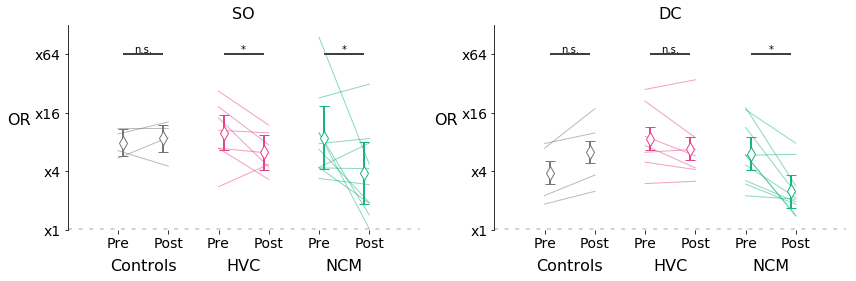

In [512]:
def pairwise_comparisons_overall(group_df, axes, x_pos, name, color):
    DX = 0.5
    
    test_sets = {"SO": [], "DC": []}
    for ax_i, call_type in enumerate(["SO", "DC"]):
        if call_type == "SO":
            call_type_data = group_df[group_df["Test Context"] == "SovsSo_8v8_d2"]
        else:
            call_type_data = group_df[group_df["Test Context"] == "DCvsDC_6v6_d2"]

        pre = []
        post = []

        for i, subject in enumerate(group_df.Subject.unique()):
            subj_data = call_type_data[call_type_data["Subject"] == subject]
            
            prelesion_set_1 = subj_data[
                (subj_data["Ladder Group"] == "PrelesionSet1")
            ]
            postlesion_set_1 = subj_data[
                (subj_data["Ladder Group"] == "PostlesionSet1")
            ]
            
            logor1 = prelesion_set_1.iloc[0]["LogOR"]
            logor2 = postlesion_set_1.iloc[0]["LogOR"]
            err1 = prelesion_set_1.iloc[0]["SE(LogOR)"]
            err2 = postlesion_set_1.iloc[0]["SE(LogOR)"]

            pre.append(logor1)
            post.append(logor2)

            axes[ax_i].plot([x_pos, x_pos + DX], [logor1, logor2], color=color, linewidth=1, alpha=0.5)
        
        axes[ax_i].set_title(call_type, fontsize=LABEL_SIZE)
        
        difference_scores = [x[1] - x[0] for x in zip(pre, post)]
        se = np.std(difference_scores)/np.sqrt(len(difference_scores)) 

        ttest_result = ttest_rel(pre, post)
        pvalue = ttest_result.pvalue
        if ttest_result.statistic > 0:
            pvalue = pvalue / 2
        else:
            pvalue = (1 - pvalue)
        is_sig = (pvalue < 0.05) and ttest_result.statistic > 0

        print("{} {} p={:.3f}{}".format(name, call_type, pvalue, "*" if is_sig else ""))

        border(axes[ax_i], 1, 0, 0, 0)
        axes[ax_i].errorbar([x_pos + 0.05, x_pos + DX - 0.05], [np.mean(pre), np.mean(post)], yerr=[2 * se, 2 * se], color=color,
                    marker="d", markersize=10, markerfacecolor="White", capsize=5,
                    linestyle="None", linewidth=2, zorder=10)
        significance_bars([x_pos + 0.05, x_pos + DX - 0.05], [6,], "*" if is_sig else "n.s.", ax=axes[ax_i])

        test_sets[call_type] = tuple(difference_scores)

    return test_sets
#     for pairs in [(0, 1), (0, 2), (1, 2)]:
#         print("SO comparisons", ttest_ind(test_sets["SO"][pairs[0]], test_sets["SO"][pairs[1]]))
#         print("DC comparisons", ttest_ind(test_sets["SO"][pairs[0]], test_sets["SO"][pairs[1]]))
    
#     axes[0].set_ylabel(name, fontsize=LABEL_SIZE)
#     plt.show()
#     plt.close(fig)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
diffs_ctrl = pairwise_comparisons_overall(ctrl_df, axes, 0, "CTRL", color=CTRL_COLOR)
diffs_hvc = pairwise_comparisons_overall(hvc_df, axes, 1, "HVC", color=HVC_COLOR)
diffs_ncm = pairwise_comparisons_overall(ncm_df, axes, 2, "NCM", color=NCM_COLOR)

for pairs in [(diffs_ctrl, diffs_hvc), (diffs_ctrl, diffs_ncm), (diffs_hvc, diffs_ncm)]:
    print("SO", ttest_ind(pairs[0]["SO"], pairs[1]["SO"]))
    print("DC", ttest_ind(pairs[0]["DC"], pairs[1]["DC"]))

DX = 0.5
for ax in axes:
    ax.set_ylim(0, 7)
    format_x_axis(ax)
    # plt.xticks([0.4, 1.4, 2.4], ["Controls", "HVC", "NCM"], fontsize=16)
    ax.set_ylabel("OR", fontsize=16, rotation=0, horizontalalignment="right")
    ax.set_yticks([0, 2, 4, 6])
    ax.set_yticklabels(["x1", "x4", "x16", "x64"], fontsize=14)
    ax.set_xlim(-DX, i + DX + DX)
    ax.hlines([0], *ax.get_xlim(), color="LightGrey", linestyle=":", linewidth=4, zorder=-1)

fig.savefig(savedir("before_and_after_recall_overall.svg"), format="svg")
plt.show()
plt.close(fig)

CTRL SO p=0.286
CTRL DC p=0.410
HVC SO p=0.572
HVC DC p=0.001*
NCM SO p=0.045*
NCM DC p=0.001*
SO Ttest_indResult(statistic=-1.0477022447547828, pvalue=0.3220958391082556)
DC Ttest_indResult(statistic=2.169021742562737, pvalue=0.058206144229035806)
SO Ttest_indResult(statistic=0.7919714789528012, pvalue=0.4437516954334526)
DC Ttest_indResult(statistic=2.37819209482245, pvalue=0.0348774395703144)
SO Ttest_indResult(statistic=1.824589148771428, pvalue=0.08804340368325421)
DC Ttest_indResult(statistic=1.2214189199179255, pvalue=0.24077767718510107)


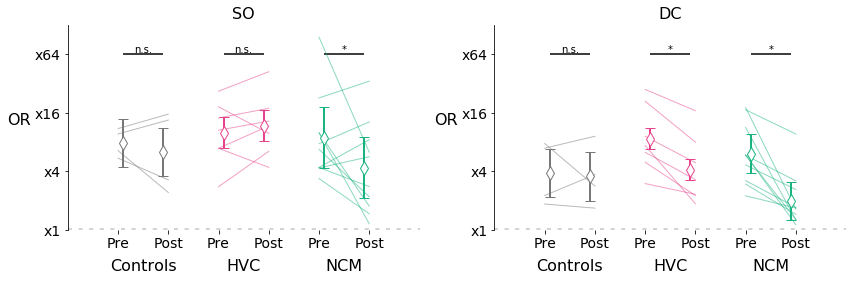

In [513]:
def pairwise_comparisons_overall_s2(group_df, axes, x_pos, name, color):
    DX = 0.5
    
    test_sets = {"SO": [], "DC": []}
    for ax_i, call_type in enumerate(["SO", "DC"]):
        if call_type == "SO":
            call_type_data = group_df[
                (group_df["Test Context"] == "SovsSo_8v8_d2") |
                (group_df["Test Context"] == "SovsSo_8v8_d2_S2")

            ]
        else:
            call_type_data = group_df[
                (group_df["Test Context"] == "DCvsDC_6v6_d2") |
                (group_df["Test Context"] == "DCvsDC_6v6_d2_S2")
            ]

        pre = []
        post = []

        for i, subject in enumerate(group_df.Subject.unique()):
            subj_data = call_type_data[call_type_data["Subject"] == subject]
            
            prelesion_set_1 = subj_data[
                (subj_data["Ladder Group"] == "PrelesionSet1")
            ]
            postlesion_set_1 = subj_data[
                (subj_data["Ladder Group"] == "PostlesionSet2")
            ]
            
            logor1 = prelesion_set_1.iloc[0]["LogOR"]
            logor2 = postlesion_set_1.iloc[0]["LogOR"]
            err1 = prelesion_set_1.iloc[0]["SE(LogOR)"]
            err2 = postlesion_set_1.iloc[0]["SE(LogOR)"]

            pre.append(logor1)
            post.append(logor2)

            axes[ax_i].plot([x_pos, x_pos + DX], [logor1, logor2], color=color, linewidth=1, alpha=0.5)
        
        axes[ax_i].set_title(call_type, fontsize=LABEL_SIZE)
        
        difference_scores = [x[1] - x[0] for x in zip(pre, post)]
        se = np.std(difference_scores)/np.sqrt(len(difference_scores)) 

        ttest_result = ttest_rel(pre, post)
        pvalue = ttest_result.pvalue
        if ttest_result.statistic > 0:
            pvalue = pvalue / 2
        else:
            pvalue = (1 - pvalue)
        is_sig = (pvalue < 0.05) and ttest_result.statistic > 0

        print("{} {} p={:.3f}{}".format(name, call_type, pvalue, "*" if is_sig else ""))

        border(axes[ax_i], 1, 0, 0, 0)
        axes[ax_i].errorbar([x_pos + 0.05, x_pos + DX - 0.05], [np.mean(pre), np.mean(post)], yerr=[2 * se, 2 * se], color=color,
                    marker="d", markersize=10, markerfacecolor="White", capsize=5,
                    linestyle="None", linewidth=2, zorder=10)
        significance_bars([x_pos + 0.05, x_pos + DX - 0.05], [6,], "*" if is_sig else "n.s.", ax=axes[ax_i])

        test_sets[call_type] = tuple(difference_scores)

    return test_sets

fig, axes = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
diffs_ctrl = pairwise_comparisons_overall_s2(ctrl_df, axes, 0, "CTRL", color=CTRL_COLOR)
diffs_hvc = pairwise_comparisons_overall_s2(hvc_df, axes, 1, "HVC", color=HVC_COLOR)
diffs_ncm = pairwise_comparisons_overall_s2(ncm_df, axes, 2, "NCM", color=NCM_COLOR)

for pairs in [(diffs_ctrl, diffs_hvc), (diffs_ctrl, diffs_ncm), (diffs_hvc, diffs_ncm)]:
    print("SO", ttest_ind(pairs[0]["SO"], pairs[1]["SO"]))
    print("DC", ttest_ind(pairs[0]["DC"], pairs[1]["DC"]))

DX = 0.5
for ax in axes:
    ax.set_ylim(0, 7)
    format_x_axis(ax)
    # plt.xticks([0.4, 1.4, 2.4], ["Controls", "HVC", "NCM"], fontsize=16)
    ax.set_ylabel("OR", fontsize=16, rotation=0, horizontalalignment="right")
    ax.set_yticks([0, 2, 4, 6])
    ax.set_yticklabels(["x1", "x4", "x16", "x64"], fontsize=14)
    ax.set_xlim(-DX, i + DX + DX)
    ax.hlines([0], *ax.get_xlim(), color="LightGrey", linestyle=":", linewidth=4, zorder=-1)

fig.savefig(savedir("before_and_after_learning_overall.svg"), format="svg", bbox_inches="tight")
plt.show()
plt.close(fig)

## Compare pre and post lesion for first informative trials

CTRL SO p=0.330
CTRL DC p=0.526
HVC SO p=0.260
HVC DC p=0.196
NCM SO p=0.001*
NCM DC p=0.021*
SO Ttest_indResult(statistic=0.012025451313646641, pvalue=0.9906676601093638)
DC Ttest_indResult(statistic=0.8460045415234467, pvalue=0.41947427107793467)
SO Ttest_indResult(statistic=1.657930125634588, pvalue=0.12322235602187702)
DC Ttest_indResult(statistic=1.6234354622527762, pvalue=0.13045622638877505)
SO Ttest_indResult(statistic=1.950557609850222, pvalue=0.0700491767252037)
DC Ttest_indResult(statistic=0.8670855125722939, pvalue=0.3995538239322298)


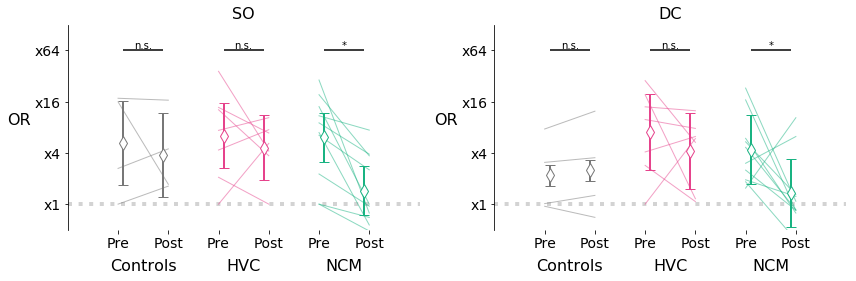

In [514]:
def pairwise_comparisons_first_info_trials(group_df, axes, x_pos, name, color):
    DX = 0.5
    
    test_sets = {"SO": [], "DC": []}
    for ax_i, call_type in enumerate(["SO", "DC"]):
        call_type_data = group_df[group_df["Call Type"] == call_type]

        pre = []
        post = []

        for i, subject in enumerate(group_df.Subject.unique()):
            subj_data = call_type_data[call_type_data["Subject"] == subject]
            
            prelesion_set_1 = subj_data[subj_data["Mode"] == "LATE_PRELESION_SET_1"]
            postlesion_set_1 = subj_data[subj_data["Mode"] == "EARLY_POSTLESION_SET_1"]
            
            logor1 = prelesion_set_1.iloc[0]["LogOR"]
            logor2 = postlesion_set_1.iloc[0]["LogOR"]
            err1 = prelesion_set_1.iloc[0]["SE(LogOR)"]
            err2 = postlesion_set_1.iloc[0]["SE(LogOR)"]

            pre.append(logor1)
            post.append(logor2)

            axes[ax_i].plot([x_pos, x_pos + DX], [logor1, logor2], color=color, linewidth=1, alpha=0.5)
        
        axes[ax_i].set_title(call_type, fontsize=LABEL_SIZE)
        
        difference_scores = [x[1] - x[0] for x in zip(pre, post)]
        se = np.std(difference_scores)/np.sqrt(len(difference_scores)) 

        ttest_result = ttest_rel(pre, post)
        pvalue = ttest_result.pvalue
        if ttest_result.statistic > 0:
            pvalue = pvalue / 2
        else:
            pvalue = (1 - pvalue)
        is_sig = (pvalue < 0.05) and ttest_result.statistic > 0

        print("{} {} p={:.3f}{}".format(name, call_type, pvalue, "*" if is_sig else ""))

        border(axes[ax_i], 1, 0, 0, 0)
        axes[ax_i].errorbar([x_pos + 0.05, x_pos + DX - 0.05], [np.mean(pre), np.mean(post)], yerr=[2 * se, 2 * se], color=color,
                    marker="d", markersize=10, markerfacecolor="White", capsize=5,
                    linestyle="None", linewidth=2, zorder=10)
        significance_bars([x_pos + 0.05, x_pos + DX - 0.05], [6,], "*" if is_sig else "n.s.", ax=axes[ax_i])

        test_sets[call_type] = tuple(difference_scores)

    return test_sets

fig, axes = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
diffs_ctrl = pairwise_comparisons_first_info_trials(ctrl_df, axes, 0, "CTRL", color=CTRL_COLOR)
diffs_hvc = pairwise_comparisons_first_info_trials(hvc_df, axes, 1, "HVC", color=HVC_COLOR)
diffs_ncm = pairwise_comparisons_first_info_trials(ncm_df, axes, 2, "NCM", color=NCM_COLOR)

for pairs in [(diffs_ctrl, diffs_hvc), (diffs_ctrl, diffs_ncm), (diffs_hvc, diffs_ncm)]:
    print("SO", ttest_ind(pairs[0]["SO"], pairs[1]["SO"]))
    print("DC", ttest_ind(pairs[0]["DC"], pairs[1]["DC"]))

DX = 0.5
for ax in axes:
    ax.set_ylim(-1, 7)
    format_x_axis(ax)
    # plt.xticks([0.4, 1.4, 2.4], ["Controls", "HVC", "NCM"], fontsize=16)
    ax.set_ylabel("OR", fontsize=16, rotation=0, horizontalalignment="right")
    ax.set_yticks([0, 2, 4, 6])
    ax.set_yticklabels(["x1", "x4", "x16", "x64"], fontsize=14)
    ax.set_xlim(-DX, i + DX + DX)
    ax.hlines([0], *ax.get_xlim(), color="LightGrey", linestyle=":", linewidth=4, zorder=-1)

fig.savefig(savedir("before_and_after_recall_3InTr.svg"), format="svg", bbox_inches="tight")
plt.show()
plt.close(fig)

In [515]:
# test_sets = []

# for i, table, color in [(0, ctrl_df, CTRL_COLOR), (1, hvc_df, HVC_COLOR), (2, ncm_df, NCM_COLOR)]:
    
#     pre = []
#     post = []
    
#     for subject in table.Subject.unique():
#         subj_df = table[table["Subject"] == subject]

#         prelesion_set_1 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2") &
#             (subj_df["Ladder Group"] == "PrelesionSet1")
#         ].iloc[0]["LogOR"]
#         err1 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2") &
#             (subj_df["Ladder Group"] == "PrelesionSet1")
#         ].iloc[0]["SE(LogOR)"]

#         postlesion_set_1 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2") &
#             (subj_df["Ladder Group"] == "PostlesionSet1")
#         ].iloc[0]["LogOR"]
#         err2 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2") &
#             (subj_df["Ladder Group"] == "PostlesionSet1")
#         ].iloc[0]["SE(LogOR)"]
        
#         pre.append(prelesion_set_1)
#         post.append(postlesion_set_1)

#         plt.plot([i, i + DX], [prelesion_set_1, postlesion_set_1], color=color, linewidth=1, alpha=0.5)
                
#     difference_scores = [x[1] - x[0] for x in zip(pre, post)]
#     se = np.std(difference_scores)/np.sqrt(len(difference_scores)) 
        
#     ttest_result = ttest_rel(pre, post)
#     pvalue = ttest_result.pvalue
#     if ttest_result.statistic > 0:
#         pvalue = pvalue / 2
#     else:
#         pvalue = (1 - pvalue)
#     print(pvalue)
#     is_sig = (pvalue < 0.05) and ttest_result.statistic > 0
    
#     border(plt.gca(), 1, 0, 0, 1)
#     plt.errorbar([i + 0.05, i + DX - 0.05], [np.mean(pre), np.mean(post)], yerr=[2 * se, 2 * se], color=color,
#                 marker="d", markersize=10, markerfacecolor="White", capsize=5,
#                 linestyle="None", linewidth=2, zorder=10)
#     significance_bars([i + 0.05, i + DX - 0.05], [6,], "*" if is_sig else "n.s.")

#     test_sets.append(tuple(difference_scores))
    
# for pairs in [(0, 1), (0, 2), (1, 2)]:
#     print(ttest_ind(test_sets[pairs[0]], test_sets[pairs[1]]))

    
# plt.ylim(0, 7)
# format_x_axis(plt.gca())
# # plt.xticks([0.4, 1.4, 2.4], ["Controls", "HVC", "NCM"], fontsize=16)
# plt.ylabel("OR", fontsize=16, rotation=0, horizontalalignment="right")
# plt.yticks([0, 2, 4, 6], ["x1", "x4", "x16", "x64"], fontsize=14)
# plt.xlim(-DX, i + DX + DX)
# plt.gcf().savefig("../notebooks/figures/3A_song.svg", format="svg", bbox_inches="tight")


In [516]:
# ### test_sets = []
# for i, table, color in [(0, ctrl_df, CTRL_COLOR), (1, hvc_df, HVC_COLOR), (2, ncm_df, NCM_COLOR)]:
#     pre = []
#     post = []

#     for subject in table.Subject.unique():
#         subj_df = table[table["Subject"] == subject]

#         prelesion_set_1 = subj_df[
#             (subj_df["Test Context"] == "DCvsDC_6v6_d2") &
#             (subj_df["Ladder Group"] == "PrelesionSet1")
#         ].iloc[0]["LogOR"]
#         err1 = subj_df[
#             (subj_df["Test Context"] == "DCvsDC_6v6_d2") &
#             (subj_df["Ladder Group"] == "PrelesionSet1")
#         ].iloc[0]["SE(LogOR)"]

#         postlesion_set_1 = subj_df[
#             (subj_df["Test Context"] == "DCvsDC_6v6_d2") &
#             (subj_df["Ladder Group"] == "PostlesionSet1")
#         ].iloc[0]["LogOR"]
#         err2 = subj_df[
#             (subj_df["Test Context"] == "DCvsDC_6v6_d2") &
#             (subj_df["Ladder Group"] == "PostlesionSet1")
#         ].iloc[0]["SE(LogOR)"]
#         pre.append(prelesion_set_1)
#         post.append(postlesion_set_1)

#         plt.plot([i, i + DX], [prelesion_set_1, postlesion_set_1], color=color, linewidth=1, alpha=0.5)
        
#     difference_scores = [x[1] - x[0] for x in zip(pre, post)]
#     se = np.std(difference_scores)/np.sqrt(len(difference_scores)) 
        
#     ttest_result = ttest_rel(pre, post)
#     pvalue = ttest_result.pvalue
#     if ttest_result.statistic > 0:
#         pvalue = pvalue / 2
#     else:
#         pvalue = (1 - pvalue)
#     print(pvalue)
#     is_sig = (pvalue < 0.05) and ttest_result.statistic > 0

#     border(plt.gca(), 1, 0, 0, 1)
#     plt.errorbar([i + 0.05, i + DX - 0.05], [np.mean(pre), np.mean(post)], yerr=[2 * se, 2 * se], color=color,
#                 marker="d", markersize=10, markerfacecolor="White", capsize=5,
#                 linestyle="None", linewidth=2, zorder=10)
#     significance_bars([i + 0.05, i + DX - 0.05], [6], "*" if is_sig else "n.s.")
    
#     test_sets.append(tuple(difference_scores))
    
# for pairs in [(0, 1), (0, 2), (1, 2)]:
#     print(ttest_ind(test_sets[pairs[0]], test_sets[pairs[1]]))


    
# plt.ylim(0, 7)
# format_x_axis(plt.gca())
# # plt.xticks([0.4, 1.4, 2.4], ["Controls", "HVC", "NCM"], fontsize=16)
# plt.ylabel("OR", fontsize=16, rotation=0, horizontalalignment="right")
# plt.yticks([0, 2, 4, 6], ["x1", "x4", "x16", "x64"], fontsize=14)
# plt.xlim(-DX, i + DX + DX)
# plt.gcf().savefig("../notebooks/figures/3B_DC.svg", format="svg", bbox_inches="tight")


0.285960404037459
0.5715632285640353
0.045434860757874125
Ttest_indResult(statistic=-1.0477022447547828, pvalue=0.3220958391082556)
Ttest_indResult(statistic=0.7919714789528012, pvalue=0.4437516954334526)
Ttest_indResult(statistic=1.824589148771428, pvalue=0.08804340368325421)


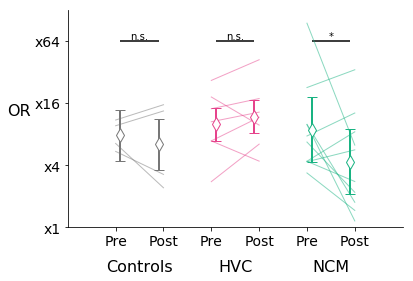

In [215]:
# test_sets = []

# for i, table, color in [(0, ctrl_df, CTRL_COLOR), (1, hvc_df, HVC_COLOR), (2, ncm_df, NCM_COLOR)]:
    
#     pre = []
#     post = []
    
#     for subject in table.Subject.unique():
#         subj_df = table[table["Subject"] == subject]

#         prelesion_set_1 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2") &
#             (subj_df["Ladder Group"] == "PrelesionSet1")
#         ].iloc[0]["LogOR"]
#         err1 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2") &
#             (subj_df["Ladder Group"] == "PrelesionSet1")
#         ].iloc[0]["SE(LogOR)"]

#         postlesion_set_1 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2_S2") &
#             (subj_df["Ladder Group"] == "PostlesionSet2")
#         ].iloc[0]["LogOR"]
#         err2 = subj_df[
#             (subj_df["Test Context"] == "SovsSo_8v8_d2_S2") &
#             (subj_df["Ladder Group"] == "PostlesionSet2")
#         ].iloc[0]["SE(LogOR)"]
        
#         pre.append(prelesion_set_1)
#         post.append(postlesion_set_1)

#         plt.plot([i, i + DX], [prelesion_set_1, postlesion_set_1], color=color, linewidth=1, alpha=0.5)
                
#     difference_scores = [x[1] - x[0] for x in zip(pre, post)]
#     se = np.std(difference_scores)/np.sqrt(len(difference_scores)) 
        
#     ttest_result = ttest_rel(pre, post)
#     pvalue = ttest_result.pvalue
#     if ttest_result.statistic > 0:
#         pvalue = pvalue / 2
#     else:
#         pvalue = (1 - pvalue)
#     print(pvalue)
#     is_sig = (pvalue < 0.05) and ttest_result.statistic > 0
    
#     border(plt.gca(), 1, 0, 0, 1)
#     plt.errorbar([i + 0.05, i + DX - 0.05], [np.mean(pre), np.mean(post)], yerr=[2 * se, 2 * se], color=color,
#                 marker="d", markersize=10, markerfacecolor="White", capsize=5,
#                 linestyle="None", linewidth=2, zorder=10)
#     significance_bars([i + 0.05, i + DX - 0.05], [6,], "*" if is_sig else "n.s.")

#     test_sets.append(tuple(difference_scores))
    
# for pairs in [(0, 1), (0, 2), (1, 2)]:
#     print(ttest_ind(test_sets[pairs[0]], test_sets[pairs[1]]))

    
# plt.ylim(0, 7)
# format_x_axis(plt.gca())
# # plt.xticks([0.4, 1.4, 2.4], ["Controls", "HVC", "NCM"], fontsize=16)
# plt.ylabel("OR", fontsize=16, rotation=0, horizontalalignment="right")
# plt.yticks([0, 2, 4, 6], ["x1", "x4", "x16", "x64"], fontsize=14)
# plt.xlim(-DX, i + DX + DX)
# plt.gcf().savefig("../notebooks/figures/3C_new_song.svg", format="svg", bbox_inches="tight")


0.41036447406137905
0.0007248844560838516
0.0005955542458784194
Ttest_indResult(statistic=-1.0477022447547828, pvalue=0.3220958391082556)
Ttest_indResult(statistic=0.7919714789528012, pvalue=0.4437516954334526)
Ttest_indResult(statistic=1.824589148771428, pvalue=0.08804340368325421)


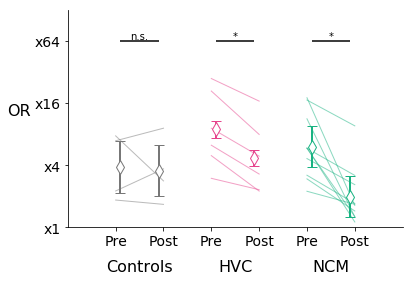

In [216]:
# ### test_sets = []
# for i, table, color in [(0, ctrl_df, CTRL_COLOR), (1, hvc_df, HVC_COLOR), (2, ncm_df, NCM_COLOR)]:
#     pre = []
#     post = []

#     for subject in table.Subject.unique():
#         # Exclude data for the subject who had health issues
#         if subject == "BluWhi3230M":
#             continue
            
#         subj_df = table[table["Subject"] == subject]

#         prelesion_set_1 = subj_df[
#             (subj_df["Test Context"] == "DCvsDC_6v6_d2") &
#             (subj_df["Ladder Group"] == "PrelesionSet1")
#         ].iloc[0]["LogOR"]
#         err1 = subj_df[
#             (subj_df["Test Context"] == "DCvsDC_6v6_d2") &
#             (subj_df["Ladder Group"] == "PrelesionSet1")
#         ].iloc[0]["SE(LogOR)"]

#         postlesion_set_1 = subj_df[
#             (subj_df["Test Context"] == "DCvsDC_6v6_d2_S2") &
#             (subj_df["Ladder Group"] == "PostlesionSet2")
#         ].iloc[0]["LogOR"]
#         err2 = subj_df[
#             (subj_df["Test Context"] == "DCvsDC_6v6_d2_S2") &
#             (subj_df["Ladder Group"] == "PostlesionSet2")
#         ].iloc[0]["SE(LogOR)"]
#         pre.append(prelesion_set_1)
#         post.append(postlesion_set_1)

#         plt.plot([i, i + DX], [prelesion_set_1, postlesion_set_1], color=color, linewidth=1, alpha=0.5)
        
#     difference_scores = [x[1] - x[0] for x in zip(pre, post)]
#     se = np.std(difference_scores)/np.sqrt(len(difference_scores)) 
        
#     ttest_result = ttest_rel(pre, post)
#     pvalue = ttest_result.pvalue
#     if ttest_result.statistic > 0:
#         pvalue = pvalue / 2
#     else:
#         pvalue = (1 - pvalue)
#     print(pvalue)
#     is_sig = (pvalue < 0.05) and ttest_result.statistic > 0

#     border(plt.gca(), 1, 0, 0, 1)
#     plt.errorbar([i + 0.05, i + DX - 0.05], [np.mean(pre), np.mean(post)], yerr=[2 * se, 2 * se], color=color,
#                 marker="d", markersize=10, markerfacecolor="White", capsize=5,
#                 linestyle="None", linewidth=2, zorder=10)
#     significance_bars([i + 0.05, i + DX - 0.05], [6], "*" if is_sig else "n.s.")
    
#     test_sets.append(tuple(difference_scores))
    
# for pairs in [(0, 1), (0, 2), (1, 2)]:
#     print(ttest_ind(test_sets[pairs[0]], test_sets[pairs[1]]))


    
# plt.ylim(0, 7)
# format_x_axis(plt.gca())
# # plt.xticks([0.4, 1.4, 2.4], ["Controls", "HVC", "NCM"], fontsize=16)
# plt.ylabel("OR", fontsize=16, rotation=0, horizontalalignment="right")
# plt.yticks([0, 2, 4, 6], ["x1", "x4", "x16", "x64"], fontsize=14)
# plt.xlim(-DX, i + DX + DX)
# plt.gcf().savefig("../notebooks/figures/3D_new_DC.svg", format="svg", bbox_inches="tight")


## (2) Does this hold (effect on NCM) when we limit the data to only those before the 3rd informative trial?

We choose 3 informative trials becuase that is approximately how many informative trials it takes for a subject to start interrupt/not-interrupt a stimulus better than chance.

The quantities are in the same in principle (log odds ratio) but are computed in a slightly different manner. In analysis (1), trials for one reward contingency (6/8 total) are evenly distributed among the stimuli in the set. Whether the subject interrupts or does not interrupt one stimulus more frequently doesn't change how many trials are evaluated.

However, when we limit our analysis to only trials before the 3rd informative trial by stimulus, the number of trials becomes biased. If a subject interrupts stimulus A more frequently, there will by definition be more trials recorded before the third informative trial of stimulus A (i.e. the first non-interrupted trial). Computing P(interrupt, rewarded) and P(interrupt, nonrewarded) over all trials across all stimuli will then bias the calculation toward stimuli with high interruption rates.

To correct for this, we calculate P(interrupt) for each invidiual stimulus, and P(interrupt, rewarded) will then be the average over the 6/8 rewarded stimuli. Now, each stimulus is weighted equally no matter how many trials were presented for that stimulus and the interruption rate to that stimulus. The log odds ratio is then $log_2(\frac{O_{re,int}}{O_{nore,int}})$, where $O_{re,int}$ is the odds of interrupting a rewarded stimulus defined by $O_{re} = \frac{p_{re}}{1 - p_{re}}$

In [369]:
# def inject_relative_informative_trials(df):
#     """Takes a dataframe with a subset of trials and injects a column of "Relative Informative Trials Seen"
#     which indicates the number of informative trials seen by a subject for a given vocalizer in the
#     selected range
#     """
#     df = df.copy()
#     df["Relative Informative Trials Seen"] = df["Informative Trials Seen"]
#     for (subj, vocalizer, call_type), subdf in df.groupby(["Subject", "Stimulus Vocalizer", "Stimulus Call Type"]):
#         df.loc[
#             subdf.index,
#             "Relative Informative Trials Seen"
#         ] -= subdf.iloc[0]["Informative Trials Seen"]
    
#     return df

# def generate_informative_trial_dataframe(df, informative_trials):
#     """Generate a dataframe with interruption data per bin per subject per stimulus
#     from the selected trials
#     """
#     # The "Informative Trials Seen" column counts informative trials seen for a given stim across
#     # all sessions run for a subject. The given dataframe may only include trials from a selected
#     # epoch which may not include the first sessions. So we create a new "Relative Informative Trials Seen"
#     # column that shows number of informative trials seen relative to the start of the requested range.
#     df = inject_relative_informative_trials(df)
#     output_rows = []
#     for bin_idx in informative_trials:
#         bin_df = df[df["Relative Informative Trials Seen"] == bin_idx]
#         for (subject, subject_sex, vocalizer, call_type, rewarded), stim_df in bin_df.groupby([
#                     "Subject", "Subject Sex", "Stimulus Vocalizer", "Stimulus Call Type", "Stimulus Class"
#                 ]):
#             output_rows.append([
#                 subject,
#                 subject_sex,
#                 vocalizer,
#                 call_type,
#                 rewarded,
#                 bin_idx,
#                 len(stim_df),
#                 np.mean(stim_df["Interrupt"])  # This should be just 1 / len(stim_df)
#             ])
            
#     return pd.DataFrame(output_rows, columns=["Subject", "Subject Sex", "Stimulus Vocalizer", "Stimulus Call Type",
#             "Stimulus Class", "Relative Informative Trials Seen", "Bin Size", "p(interrupt)"])

# def process_first_n_informative_trials(df, n=2):
#     """Assess interruption rates and odds ratio in first n informative trials (inclusive)
#     """
#     inform_df = generate_informative_trial_dataframe(df, np.arange(n))
#     # The following line ensures that we bin 0&1 into bin 0, 2&3 into bin 2, etc
#     subdf = inform_df[inform_df["Relative Informative Trials Seen"] <= n]
#     re = subdf[subdf["Stimulus Class"] == "Rewarded"]
#     nore = subdf[subdf["Stimulus Class"] == "Nonrewarded"]
    
#     if not len(re):
#         raise ValueError("No rewarded stimuli found")
#     if not len(nore):
#         raise ValueError("No nonrewarded stimuli found")

#     if len(re) != len(nore):
#         raise Exception("Different number of rewarded stimuli than nonrewarded")

#     p_re, sem_re = jackknife(re["p(interrupt)"], np.mean)
#     p_nore, sem_nore = jackknife(nore["p(interrupt)"], np.mean)

#     if p_re == 0:
#         p_re = 0.5 / len(re["p(interrupt)"])

#     if p_nore == 0:
#         p_nore = 0.5 / len(nore["p(interrupt)"])

#     def _logor(p_re, p_nore):
#         p_re = np.mean(p_re)
#         p_nore = np.mean(p_nore)

#         if p_re == 0:
#             p_re = 0.5 / len(re["p(interrupt)"])

#         if p_nore == 0:
#             p_nore = 0.5 / len(nore["p(interrupt)"])

#         return np.log2(p_nore / (1 - p_nore)) - np.log2(p_re / (1 - p_re))

#     logor = _logor(re["p(interrupt)"], nore["p(interrupt)"])
#     logor_sem = bootstrap(_logor, re["p(interrupt)"], nore["p(interrupt)"])
    
#     return {
#         "p_re": p_re,
#         "p_nore": p_nore,
#         "sem_re": sem_re,
#         "sem_nore": sem_nore,
#         "logor": logor,
#         "logor_sem": logor_sem
#     }

In [117]:
# song_prelesion_late = trial_data[
#     (trial_data["Ladder Group"] == "PrelesionSet1") &
#     (trial_data["Stimulus Call Type"] == "SO") &
#     (trial_data["Test Context"] == "SovsSo_8v8_d2")
# ]
# song_postlesion_early = trial_data[
#     (trial_data["Ladder Group"] == "PostlesionSet1") &
#     (trial_data["Stimulus Call Type"] == "SO")
# ]

0.33014749020765866
0.2601123496606586
0.0012310748094145991


([<matplotlib.axis.YTick at 0x7f22bd47d358>,
 <a list of 4 Text yticklabel objects>)

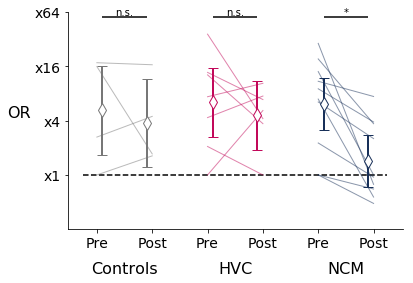

In [119]:
# for i, table, color in [(0, ctrl_df, CTRL_COLOR), (1, hvc_df, HVC_COLOR), (2, ncm_df, NCM_COLOR)]:
#     pre = []
#     post = []

#     for subject in table.Subject.unique():
        
#         prelesion_data = process_first_n_informative_trials(
#             song_prelesion_late[song_prelesion_late["Subject"] == subject],
#             2
#         )
#         postlesion_data = process_first_n_informative_trials(
#             song_postlesion_early[song_postlesion_early["Subject"] == subject],
#             2
#         )
        
#         prelesion_set_1 = prelesion_data["logor"]
#         postlesion_set_1 = postlesion_data["logor"]
#         plt.plot([i, i + DX], [prelesion_set_1, postlesion_set_1], color=color, linewidth=1, alpha=0.5)
#         pre.append(prelesion_set_1)
#         post.append(postlesion_set_1)
        
#     difference_scores = [x[1] - x[0] for x in zip(pre, post)]
#     se = np.std(difference_scores)/np.sqrt(len(difference_scores)) 
        
#     ttest_result = ttest_rel(pre, post)
#     pvalue = ttest_result.pvalue
#     if ttest_result.statistic > 0:
#         pvalue = pvalue / 2
#     else:
#         pvalue = (1 - pvalue)
#     print(pvalue)
#     is_sig = (pvalue < 0.05) and ttest_result.statistic > 0

#     border(plt.gca(), 1, 0, 0, 1)
#     plt.errorbar([i + 0.05, i + DX - 0.05], [np.mean(pre), np.mean(post)], yerr=[2 * se, 2 * se], color=color,
#                 marker="d", markersize=10, markerfacecolor="White", capsize=5,
#                 linestyle="None", linewidth=2, zorder=10)
#     significance_bars([i + 0.05, i + DX - 0.05], [5.8], "*" if is_sig else "n.s.")

    
# plt.ylim(-2, 6)
# format_x_axis(plt.gca())
# plt.hlines(0, *plt.xlim(), linestyle="--", color="Black", zorder=-1)

# # plt.xticks([0.4, 1.4, 2.4], ["Controls", "HVC", "NCM"], fontsize=16)
# plt.ylabel("OR", fontsize=16, rotation=0, horizontalalignment="right")
# plt.yticks([0, 2, 4, 6], ["x1", "x4", "x16", "x64"], fontsize=14)


In [120]:
# dc_prelesion_late = trial_data[
#     (trial_data["Ladder Group"] == "PrelesionSet1") &
#     (trial_data["Stimulus Call Type"] == "DC") &
#     (trial_data["Test Context"] == "DCvsDC_6v6_d2")
# ]
# dc_postlesion_early = trial_data[
#     (trial_data["Ladder Group"] == "PostlesionSet1") &
#     (trial_data["Stimulus Call Type"] == "DC")
# ]

0.5260418004408509
0.19600963672184918
0.020647677628214383


([<matplotlib.axis.YTick at 0x7f22bd3eb0f0>,
 <a list of 4 Text yticklabel objects>)

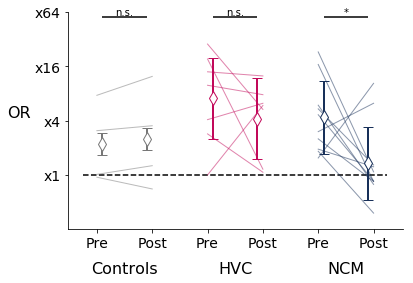

In [121]:
# for i, table, color in [(0, ctrl_df, CTRL_COLOR), (1, hvc_df, HVC_COLOR), (2, ncm_df, NCM_COLOR)]:
#     pre = []
#     post = []

#     for subject in table.Subject.unique():
        
#         prelesion_data = process_first_n_informative_trials(
#             dc_prelesion_late[dc_prelesion_late["Subject"] == subject],
#             2
#         )
#         postlesion_data = process_first_n_informative_trials(
#             dc_postlesion_early[dc_postlesion_early["Subject"] == subject],
#             2
#         )
        
#         prelesion_set_1 = prelesion_data["logor"]
#         postlesion_set_1 = postlesion_data["logor"]
#         plt.plot([i, i + DX], [prelesion_set_1, postlesion_set_1], color=color, linewidth=1, alpha=0.5)
#         pre.append(prelesion_set_1)
#         post.append(postlesion_set_1)
        
#     difference_scores = [x[1] - x[0] for x in zip(pre, post)]
#     se = np.std(difference_scores)/np.sqrt(len(difference_scores)) 
        
#     ttest_result = ttest_rel(pre, post)
#     pvalue = ttest_result.pvalue
#     if ttest_result.statistic > 0:
#         pvalue = pvalue / 2
#     else:
#         pvalue = (1 - pvalue)
#     print(pvalue)
#     is_sig = (pvalue < 0.05) and ttest_result.statistic > 0

#     border(plt.gca(), 1, 0, 0, 1)
#     plt.errorbar([i + 0.05, i + DX - 0.05], [np.mean(pre), np.mean(post)], yerr=[2 * se, 2 * se], color=color,
#                 marker="d", markersize=10, markerfacecolor="White", capsize=5,
#                 linestyle="None", linewidth=2, zorder=10)
#     significance_bars([i + 0.05, i + DX - 0.05], [5.8], "*" if is_sig else "n.s.")
    
# plt.ylim(-2, 6)
# format_x_axis(plt.gca())
# # plt.xticks([0.4, 1.4, 2.4], ["Controls", "HVC", "NCM"], fontsize=16)
# plt.hlines(0, *plt.xlim(), linestyle="--", color="Black", zorder=-1)
# plt.ylabel("OR", fontsize=16, rotation=0, horizontalalignment="right")
# plt.yticks([0, 2, 4, 6], ["x1", "x4", "x16", "x64"], fontsize=14)



## (2) Correlating with lesion size

In [591]:
def overlay_regression(x, lin, r_adj, cc, topright=True, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    xarr = np.linspace(np.min(x), np.max(x) * 1.1, 3)
    ax.plot(xarr, 2 ** lin(xarr), **kwargs)
    ax.text(
        1,
        1 if topright else 0,
        "$R^2_{{adj}} = {:.2f}$\n$CC = {:.2f}$".format(r_adj, cc), 
        verticalalignment="top" if topright else "bottom", 
        horizontalalignment="right",
        color=kwargs.get("color"),
        transform=ax.transAxes
    )

def lesion_analysis(df, ax=None):
    """Plot and regress the odds ratio vs lesion volume
    """
    if ax is None:
        ax = plt.gca()

    # Do a linear regression
    # Exclude HVC!
    
    
    popt, pcov, lin, r_squared, r_adj, sigma_ab = linreg(
        df["Lesion"][df["Treatment"] != "HVC"],
        np.log2(df["OR_ratio"][df["Treatment"] != "HVC"])
    )
    cc, _ = pearsonr(df["Lesion"][df["Treatment"] != "HVC"], np.log2(df["OR_ratio"][df["Treatment"] != "HVC"]))
    
    ax.scatter(
        df["Lesion"][df["Treatment"] != "HVC"],
        df["OR_ratio"][df["Treatment"] != "HVC"],
        color="Black",
        facecolor="None",
        linewidth=1,
        s=80
    )
    
    # Temporary highlights for data of interest
    ax.scatter(
        df["Lesion"][df["Treatment"] == "HVC"],
        df["OR_ratio"][df["Treatment"] == "HVC"],
        color=HVC_COLOR,
        facecolor="None",
        s=60,
        linewidth=2,
        label="HVC lesions"
    )
    
    ax.scatter(
        df["Lesion"][df["Subject"].isin(POTENTIAL_L)],
        df["OR_ratio"][df["Subject"].isin(POTENTIAL_L)],
        color="None",
        facecolor="Black",
        s=20,
#         linewidth=2,
        label="Potential field L damage"
    )
    
    ax.scatter(
        df["Lesion"][df["Subject"] == "HpiGre0651M"],
        df["OR_ratio"][df["Subject"] == "HpiGre0651M"],
        color="None",
        facecolor="Orange",
        s=20,
#         linewidth=2,
        label="HpiGre0651M",
    )


    print("Excluding hvc")
    print(df)
    print(r_squared, r_adj)
    # Plot best fit line
    overlay_regression(df["Lesion"], lin, r_adj, cc, ax=ax, color="Grey", linestyle="--")
    

    popt, pcov, lin, r_squared, r_adj, sigma_ab = linreg(
        df["Lesion"],
        np.log2(df["OR_ratio"])
    )
    cc, _ = pearsonr(df["Lesion"], np.log2(df["OR_ratio"]))
    print("Including hvc")
    print(r_squared, r_adj)
    overlay_regression(df["Lesion"], lin, r_adj, cc, topright=False, ax=ax, color=HVC_COLOR, linestyle="--")

    
    ax.set_ylabel(r"$\frac{OR_{post}}{OR_{pre}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")
    ax.set_xlabel("Lesion Size ($mm^3$)", fontsize=20)
    border(ax, 1, 0, 0, 1)
    return r_adj, cc

# def before_and_after_comparison(ladder_set_grouper, set1, set2):
#     """Create plot comparing odds ratios before and after lesion directly
#     """
    
#     fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
    
#     for (subject, ctx), subj_df in ladder_set_grouper:
#         prelesion_OR, prelesion_lower_bound = lesions_by_performance_df[
#             (lesions_by_performance_df["Subject"] == subject)
#             & (lesions_by_performance_df["Ladder Group"] == set1)
#             & (lesions_by_performance_df["Test Context"] == ctx)
#         ].iloc[0][["Odds Ratio", "95 CI Lower"]]
#         postlesion_OR, postlesion_lower_bound = subj_df[subj_df["Ladder Group"] == set2].iloc[0][["Odds Ratio", "95 CI Lower"]]
        
#         lesion_size = subj_df.iloc[0]["Total_Lesion_Size"] * 1e-9
#         if lesion_size < 0.2:
#             x = [0, 1]
#         else:
#             x = [1.2, 2.2]
        
#         if "So" in ctx:
#             ax = axes[0]
#             ax.set_title("Song")
#         elif "DC" in ctx:
#             ax = axes[1]
#             ax.set_title("DC")
        
#         ax.errorbar(
#             x,
#             [prelesion_OR, postlesion_OR],
#             yerr=[prelesion_OR - prelesion_lower_bound,
#                  postlesion_OR - postlesion_lower_bound],
#             color="Black")

#     for ax in axes:
#         ax.set_yscale("log")
#         ax.set_xlim(-0.2, 2.4)
#         ax.set_xticks([0.5, 1.7])
#         ax.set_xticklabels(["Control", "Lesion"])
#         border(ax, 1, 0, 0, 1)
    
#     fig.suptitle("Prelesion vs Postlesion (Same Stims)", fontsize=16)
#     axes[0].set_ylabel("OR", rotation=0, fontsize=16)
#     plt.show()
#     plt.close(fig)
        


In [592]:
lesions_by_performance_df = lesion_data.merge(performance_df, on="Subject")

In [593]:
# Collapse the rows belonging to the same test context by subject

results = []
ladder_set_grouper = lesions_by_performance_df[
    (lesions_by_performance_df["Ladder Group"] == "PostlesionSet1") &
    (lesions_by_performance_df["Mode"] == "OVERALL")
].groupby(["Subject", "Test Context"])

for (subject, ctx), subj_df in ladder_set_grouper:
    prelesion_OR = lesions_by_performance_df[
        (lesions_by_performance_df["Subject"] == subject)
        & (lesions_by_performance_df["Ladder Group"] == "PrelesionSet1")
        & (lesions_by_performance_df["Test Context"] == ctx)
    ].iloc[0]["Odds Ratio"]
    postlesion_OR = subj_df[subj_df["Ladder Group"] == "PostlesionSet1"].iloc[0]["Odds Ratio"]
    
    results.append({
        "call_type": "So" if ctx == "SovsSo_8v8_d2" else "DC",
        "OR_ratio": postlesion_OR / prelesion_OR,
        "Lesion": subj_df.iloc[0]["Total_Lesion_Size"] * 1e-9,
        "Treatment": subj_df.iloc[0]["Treatment"],
        "Subject": subject,
    })
results = pd.DataFrame(results)

0.08124801657995218 0.004685351294948181 14 1
Excluding hvc
      Lesion  OR_ratio      Subject Treatment call_type
1   0.517551  1.598629  BlaGre1349M       NCM        So
3   0.000000  0.314306  BluGre4315M       HVC        So
5   0.000000  0.849528  BluRed8773M       HVC        So
7   0.000000  2.148076  BluWhi0398F       HVC        So
9   0.000000  0.911570  BluWhi3230M       HVC        So
11  0.000000  1.510641  BluYel2571F      CTRL        So
13  0.329430  0.295537  GraWhi4040F       NCM        So
15  0.000000  0.273661  GraYel7337F       HVC        So
17  0.422983  0.975134  GreBla3404M       NCM        So
19  0.303389  2.300808  GreBlu5039F       NCM        So
21  0.000000  0.187836  GreWhi2703M       HVC        So
23  0.990187  0.163177  HpiGre0651M       NCM        So
25  0.000000  0.345193  HpiGre8613M       HVC        So
27  0.000000  1.004634  RedGra7912M      CTRL        So
29  0.506958  0.060180  RedHpi0710F       NCM        So
31  1.389358  0.810520  WhiBlu5805F       NC

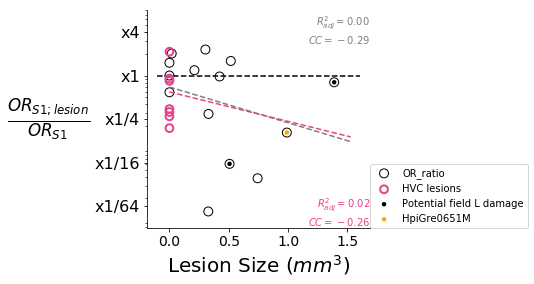

In [594]:
fig = plt.figure(figsize=(4, 4))
r_adj, cc = lesion_analysis(results.query("call_type == 'So'"))
plt.xticks(fontsize=14)
plt.gca().set_ylabel(r"$\frac{OR_{S1;lesion}}{OR_{S1}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")

set_oddsratio_yticks(plt.gca(), 3, -7, set_label=False)
plt.legend(loc=(1, 0))
fig.savefig(savedir("lesion_size_regression_plot_song.svg"), format="svg", bbox_inches="tight")
plt.show()
plt.close(fig)

0.3318510141221368 0.27617193196564827 14 1
Excluding hvc
      Lesion  OR_ratio      Subject Treatment call_type
0   0.517551  0.319130  BlaGre1349M       NCM        DC
2   0.000000  1.390997  BluGre4315M       HVC        DC
4   0.000000  0.513854  BluRed8773M       HVC        DC
6   0.000000  1.081969  BluWhi0398F       HVC        DC
8   0.000000  0.466689  BluWhi3230M       HVC        DC
10  0.000000  2.008858  BluYel2571F      CTRL        DC
12  0.329430  0.325913  GraWhi4040F       NCM        DC
14  0.000000  1.109263  GraYel7337F       HVC        DC
16  0.422983  0.888974  GreBla3404M       NCM        DC
18  0.303389  0.484941  GreBlu5039F       NCM        DC
20  0.000000  0.288560  GreWhi2703M       HVC        DC
22  0.990187  0.105430  HpiGre0651M       NCM        DC
24  0.000000  0.776258  HpiGre8613M       HVC        DC
26  0.000000  3.842736  RedGra7912M      CTRL        DC
28  0.506958  0.129481  RedHpi0710F       NCM        DC
30  1.389358  0.502318  WhiBlu5805F       NCM 

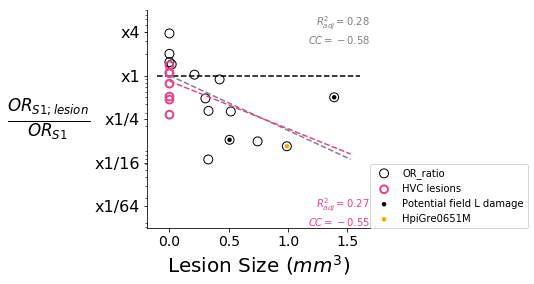

In [595]:
fig = plt.figure(figsize=(4, 4))
r_adj, cc = lesion_analysis(results.query("call_type == 'DC'"))
set_oddsratio_yticks(plt.gca(), 3, -7, set_label=False)
plt.xticks(fontsize=14)
plt.gca().set_ylabel(r"$\frac{OR_{S1;lesion}}{OR_{S1}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")

plt.legend(loc=(1, 0))
fig.savefig(savedir("lesion_size_regression_plot_DC.svg"), format="svg", bbox_inches="tight")

plt.show()
plt.close(fig)

## Figure 5. Effect of lesion on learning new stimuli

In [596]:
# Collapse the rows belonging to the same test context by subject

new_set_results = []
new_set_ladder_set_grouper = lesions_by_performance_df[
    (lesions_by_performance_df["Ladder Group"] == "PostlesionSet2") &
    (lesions_by_performance_df["Mode"] == "OVERALL")
].groupby(["Subject", "Test Context"])

for (subject, ctx), subj_df in new_set_ladder_set_grouper:
    assert ctx.endswith("S2")
    prelesion_OR = lesions_by_performance_df[
        (lesions_by_performance_df["Subject"] == subject)
        & (lesions_by_performance_df["Ladder Group"] == "PrelesionSet1")
        & (lesions_by_performance_df["Test Context"] == ctx[:-3])  # Strip the _S2 from end of ctx
    ].iloc[0]["Odds Ratio"]
    postlesion_OR = subj_df[subj_df["Ladder Group"] == "PostlesionSet2"].iloc[0]["Odds Ratio"]
    
    new_set_results.append({
        "call_type": "So" if ctx == "SovsSo_8v8_d2_S2" else "DC",
        "OR_ratio": postlesion_OR / prelesion_OR,
        "Lesion": subj_df.iloc[0]["Total_Lesion_Size"] * 1e-9,
        "Treatment": subj_df.iloc[0]["Treatment"],
        "Subject": subject,
    })
new_set_results = pd.DataFrame(new_set_results)

0.10920380091732573 0.03497078432710288 14 1
Excluding hvc
      Lesion  OR_ratio      Subject Treatment call_type
1   0.517551  1.771809  BlaGre1349M       NCM        So
3   0.000000  1.945092  BluGre4315M       HVC        So
5   0.000000  2.138425  BluRed8773M       HVC        So
7   0.000000  3.346905  BluWhi0398F       HVC        So
9   0.000000  1.362767  BluWhi3230M       HVC        So
11  0.000000  1.609153  BluYel2571F      CTRL        So
13  0.329430  0.521844  GraWhi4040F       NCM        So
15  0.000000  0.404575  GraYel7337F       HVC        So
17  0.422983  1.467670  GreBla3404M       NCM        So
19  0.303389  2.576455  GreBlu5039F       NCM        So
21  0.000000  1.388953  GreWhi2703M       HVC        So
23  0.990187  0.198404  HpiGre0651M       NCM        So
25  0.000000  0.522055  HpiGre8613M       HVC        So
27  0.000000  1.636092  RedGra7912M      CTRL        So
29  0.506958  0.081403  RedHpi0710F       NCM        So
31  1.389358  0.299480  WhiBlu5805F       NCM

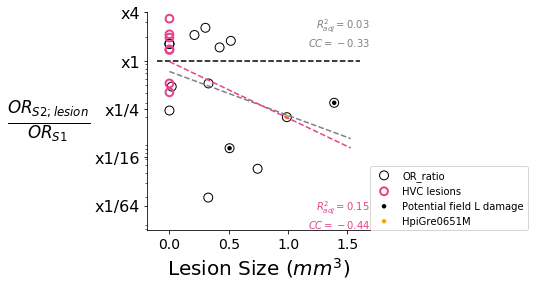

In [597]:
fig = plt.figure(figsize=(4, 4))
r_adj, cc = lesion_analysis(new_set_results.query("call_type == 'So'"))
set_oddsratio_yticks(plt.gca(), 2, -7, set_label=False)
plt.xticks(fontsize=14)

plt.gca().set_ylabel(r"$\frac{OR_{S2;lesion}}{OR_{S1}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")
plt.legend(loc=(1, 0))
fig.savefig(savedir("lesion_size_regression_new_set_plot_song.svg"), format="svg", bbox_inches="tight")

plt.show()
plt.close(fig)

,Lesion,OR_ratio,Subject,Treatment,call_type
0,0.517551,0.435716,BlaGre1349M,NCM,DC
2,0.000000,0.483396,BluGre4315M,HVC,DC
4,0.000000,0.406715,BluRed8773M,HVC,DC
6,0.000000,0.693385,BluWhi0398F,HVC,DC
10,0.000000,2.038428,BluYel2571F,CTRL,DC
12,0.329430,0.432156,GraWhi4040F,NCM,DC
14,0.000000,0.395286,GraYel7337F,HVC,DC
16,0.422983,0.657078,GreBla3404M,NCM,DC
18,0.303389,0.403069,GreBlu5039F,NCM,DC
20,0.000000,0.247517,GreWhi2703M,HVC,DC


0.22964078280654976 0.16544418137376227 14 1
Excluding hvc
      Lesion  OR_ratio      Subject Treatment call_type
0   0.517551  0.435716  BlaGre1349M       NCM        DC
2   0.000000  0.483396  BluGre4315M       HVC        DC
4   0.000000  0.406715  BluRed8773M       HVC        DC
6   0.000000  0.693385  BluWhi0398F       HVC        DC
10  0.000000  2.038428  BluYel2571F      CTRL        DC
12  0.329430  0.432156  GraWhi4040F       NCM        DC
14  0.000000  0.395286  GraYel7337F       HVC        DC
16  0.422983  0.657078  GreBla3404M       NCM        DC
18  0.303389  0.403069  GreBlu5039F       NCM        DC
20  0.000000  0.247517  GreWhi2703M       HVC        DC
22  0.990187  0.042534  HpiGre0651M       NCM        DC
24  0.000000  0.319721  HpiGre8613M       HVC        DC
26  0.000000  1.499202  RedGra7912M      CTRL        DC
28  0.506958  0.111518  RedHpi0710F       NCM        DC
30  1.389358  0.355892  WhiBlu5805F       NCM        DC
32  0.019118  0.234551  WhiWhi2526M      CTRL

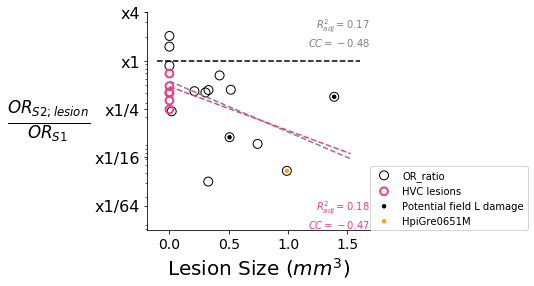

In [598]:
fig = plt.figure(figsize=(4, 4))

new_set_dc_results = new_set_results.query("call_type == 'DC'")
new_set_dc_results = new_set_dc_results[new_set_dc_results["Subject"] != "BluWhi3230M"]
display(new_set_dc_results)
r_adj, cc = lesion_analysis(new_set_dc_results)
set_oddsratio_yticks(plt.gca(), 2, -7, set_label=False)
plt.gca().set_ylabel(r"$\frac{OR_{S2;lesion}}{OR_{S1}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")
plt.legend(loc=(1, 0))
plt.xticks(fontsize=14)

fig.savefig(savedir("lesion_size_regression_new_set_plot_DC.svg"), format="svg", bbox_inches="tight")

plt.show()
plt.close(fig)

## How do the lesion sizes affect the plots for early postlesion vs late prelesion

In [599]:
results = []
ladder_set_grouper = lesions_by_performance_df[
    (lesions_by_performance_df["Ladder Group"] == "PostlesionSet1") &
    (lesions_by_performance_df["Mode"] == "EARLY_POSTLESION_SET_1")
].groupby(["Subject", "Call Type"])

for (subject, call_type), subj_df in ladder_set_grouper:
    prelesion_OR = lesions_by_performance_df[
        (lesions_by_performance_df["Subject"] == subject)
        & (lesions_by_performance_df["Ladder Group"] == "PrelesionSet1")
        & (lesions_by_performance_df["Mode"] == "LATE_PRELESION_SET_1")
        & (lesions_by_performance_df["Call Type"] == call_type)
    ].iloc[0]["Odds Ratio"]
    postlesion_OR = subj_df.iloc[0]["Odds Ratio"]
    
    results.append({
        "call_type": "So" if call_type == "SO" else "DC",
        "OR_ratio": postlesion_OR / prelesion_OR,
        "Lesion": subj_df.iloc[0]["Total_Lesion_Size"] * 1e-9,
        "Treatment": subj_df.iloc[0]["Treatment"],
        "Subject": subject,
    })
results = pd.DataFrame(results)

0.058159355112972655 -0.020327365294279476 14 1
Excluding hvc
      Lesion  OR_ratio      Subject Treatment call_type
1   0.517551  0.678883  BlaGre1349M       NCM        So
3   0.000000  1.408406  BluGre4315M       HVC        So
5   0.000000  0.115965  BluRed8773M       HVC        So
7   0.000000  1.732161  BluWhi0398F       HVC        So
9   0.000000  0.288460  BluWhi3230M       HVC        So
11  0.000000  0.107750  BluYel2571F      CTRL        So
13  0.329430  0.698824  GraWhi4040F       NCM        So
15  0.000000  5.168067  GraYel7337F       HVC        So
17  0.422983  0.419254  GreBla3404M       NCM        So
19  0.303389  0.071661  GreBlu5039F       NCM        So
21  0.000000  0.500712  GreWhi2703M       HVC        So
23  0.990187  0.483871  HpiGre0651M       NCM        So
25  0.000000  0.483871  HpiGre8613M       HVC        So
27  0.000000  0.949369  RedGra7912M      CTRL        So
29  0.506958  0.082222  RedHpi0710F       NCM        So
31  1.389358  0.392711  WhiBlu5805F       

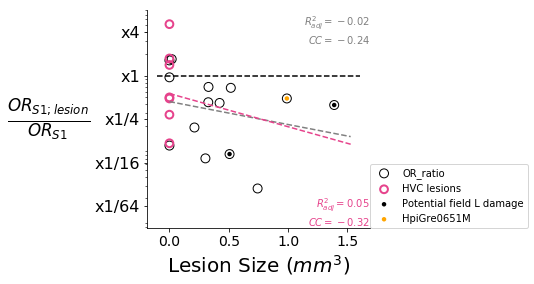

In [600]:
fig = plt.figure(figsize=(4, 4))
r_adj, cc = lesion_analysis(results.query("call_type == 'So'"))
plt.xticks(fontsize=14)
plt.gca().set_ylabel(r"$\frac{OR_{S1;lesion}}{OR_{S1}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")

set_oddsratio_yticks(plt.gca(), 3, -7, set_label=False)
plt.legend(loc=(1, 0))
fig.savefig(savedir("lesion_size_regression_3InTr_plot_song.svg"), format="svg", bbox_inches="tight")

plt.show()
plt.close(fig)

0.025680547318072566 -0.055512740405421424 14 1
Excluding hvc
      Lesion  OR_ratio      Subject Treatment call_type
0   0.517551  0.050493  BlaGre1349M       NCM        DC
2   0.000000  0.899701  BluGre4315M       HVC        DC
4   0.000000  0.786748  BluRed8773M       HVC        DC
6   0.000000  0.376115  BluWhi0398F       HVC        DC
8   0.000000  1.517335  BluWhi3230M       HVC        DC
10  0.000000  0.741253  BluYel2571F      CTRL        DC
12  0.329430  0.184847  GraWhi4040F       NCM        DC
14  0.000000  0.060233  GraYel7337F       HVC        DC
16  0.422983  0.206721  GreBla3404M       NCM        DC
18  0.303389  0.638215  GreBlu5039F       NCM        DC
20  0.000000  0.188923  GreWhi2703M       HVC        DC
22  0.990187  0.338118  HpiGre0651M       NCM        DC
24  0.000000  5.878505  HpiGre8613M       HVC        DC
26  0.000000  1.618553  RedGra7912M      CTRL        DC
28  0.506958  0.239307  RedHpi0710F       NCM        DC
30  1.389358  2.061140  WhiBlu5805F       

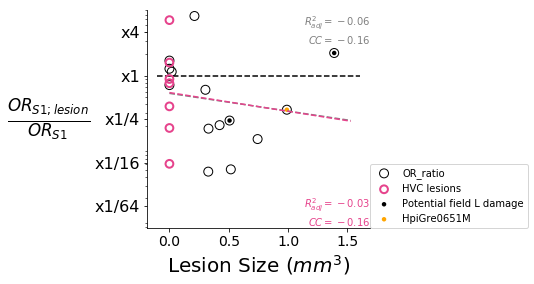

In [601]:
fig = plt.figure(figsize=(4, 4))
r_adj, cc = lesion_analysis(results.query("call_type == 'DC'"))
plt.xticks(fontsize=14)
plt.gca().set_ylabel(r"$\frac{OR_{S1;lesion}}{OR_{S1}}$", fontsize=24, rotation=0, verticalalignment="center", horizontalalignment="right")

set_oddsratio_yticks(plt.gca(), 3, -7, set_label=False)
plt.legend(loc=(1, 0))
fig.savefig(savedir("lesion_size_regression_3InTr_plot_DC.svg"), format="svg", bbox_inches="tight")

plt.show()
plt.close(fig)

In [603]:
pwd

'/auto/fhome/kevin/Projects/zebra-finch-memory-lesions/paper_notebooks'

## Supplemental Figures? Learning plots after lesion

Learning curves and generalization curves on the second set of stimuli for only NCM subjects

In [602]:
def process_learning_curve_data(df, informative_trials):
    """
    Collect probability of interruption across subjects in each informative trial bin
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    inform_df = generate_informative_trial_dataframe(df, informative_trials)
    
    grouped_by_informative_trials = inform_df.groupby([
        "Subject", "Relative Informative Trials Seen", "Stimulus Class"
    ]).mean()["p(interrupt)"]

    binned = grouped_by_informative_trials.groupby(
        ["Relative Informative Trials Seen", "Stimulus Class"],
    )
    
    output_rows = []
    for (bin_idx, rewarded), subdf in binned:
        mean, sem = jackknife(subdf, np.mean)
        output_rows.append([bin_idx, rewarded, mean, sem])
    output = pd.DataFrame(output_rows, columns=["Informative Trials", "Stimulus Class", "p(interrupt)", "SEM"])
    output = output.sort_values(["Informative Trials", "Stimulus Class"])

    return output


def plot_learning_curve(df, informative_trials, ax, fill_kwargs, n_sem=2, line_kwargs=None):
    """
    Plot the learning curve across subjects for the given trials
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    learning_df = process_learning_curve_data(df, informative_trials)
    
    for stimulus_class in ["Rewarded", "Nonrewarded"]:
        subdf = learning_df[learning_df["Stimulus Class"] == stimulus_class]
        ax.fill_between(
            subdf["Informative Trials"],
            subdf["p(interrupt)"] - 2 * subdf["SEM"],
            subdf["p(interrupt)"] + 2 * subdf["SEM"],
            color=color_by_reward.get(stimulus_class),
            **fill_kwargs
        )
        if line_kwargs is not None:
            ax.plot(
                subdf["Informative Trials"],
                subdf["p(interrupt)"],
                color=color_by_reward.get(stimulus_class),
                **line_kwargs
            )
    return learning_df


def plot_learning_curves_side_by_side(df1, df2, informative_trials, ylim=(0, 1)):
    fig = plt.figure(figsize=(10, 4))

    ax_left = fig.add_axes([0.1, 0.1, 0.4, 0.8])
    ax_right = fig.add_axes([0.6, 0.1, 0.4, 0.8])

    df1 = plot_learning_curve(
        df1,
        informative_trials,
        ax_left,
        fill_kwargs=dict(
            alpha=0.2,
            zorder=-1,
        ),
        line_kwargs = dict(
            marker="x",
            markersize=8,
        )
    )

    df2 = plot_learning_curve(
        df2,
        informative_trials,
        ax_right,
        fill_kwargs=dict(
            alpha=0.3,
            zorder=-1,
        ),
        line_kwargs = dict(
            marker="o",
            markersize=5,
        )
    )

    for ax in [ax_left, ax_right]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        #Create legend from custom artist/label lists
        if ax is ax_right:
            unreartist = plt.Line2D((0,1),(0,0), color=color_by_reward.get("Unrewarded"), marker='', linestyle='-')
            reartist = plt.Line2D((0,1),(0,0), color=color_by_reward.get("Rewarded"), marker='', linestyle='-')
            dc_artist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='-', markersize=8)
            song_artist = plt.Line2D((0,1),(0,0), color='k', marker='x', linestyle='-')
            ax.legend(
                [unreartist, reartist, dc_artist, song_artist], 
                ["NoRe", "Re", "DC", "Song"],
                ncol=2, 
                frameon=False,
                fontsize=16
            )

        # Set limits and axes of plot
        xticks = np.arange(0, np.max(informative_trials) + 2, 10).astype(np.int)
        ax.set_xlim(0, np.max(informative_trials))
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks, fontsize=16)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)

        if ax is ax_left:
            ax.set_ylabel("Prob. of interruption", fontsize=16)
        ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)

        ax.set_ylim(*ylim)

    return fig, df1, df2


def plot_learning_curves_one(df1, informative_trials, ylim=(0, 1)):
    fig = plt.figure(figsize=(5, 4))
    ax = plt.gca()

    df1 = plot_learning_curve(
        df1,
        informative_trials,
        ax,
        fill_kwargs=dict(
            alpha=0.2,
            zorder=-1,
        ),
        line_kwargs = dict(
            marker="o",
            markersize=6,
        )
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    #Create legend from custom artist/label lists
    unreartist = plt.Line2D((0,1),(0,0), color=color_by_reward.get("Unrewarded"), marker='', linestyle='-')
    reartist = plt.Line2D((0,1),(0,0), color=color_by_reward.get("Rewarded"), marker='', linestyle='-')
    ax.legend(
        [unreartist, reartist], 
        ["NoRe", "Re"],
        ncol=1, 
        frameon=False,
        fontsize=16
    )

    # Set limits and axes of plot
    xticks = np.arange(0, np.max(informative_trials) + 2, 10).astype(np.int)
    ax.set_xlim(0, np.max(informative_trials))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=16)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)

    ax.set_ylabel("Prob. of interruption", fontsize=16)
    ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)

    ax.set_ylim(*ylim)

    return fig, df1

## Learning curves set 1 pre vs post lesion

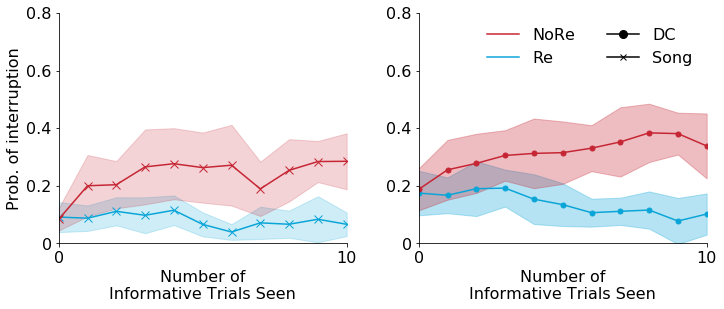

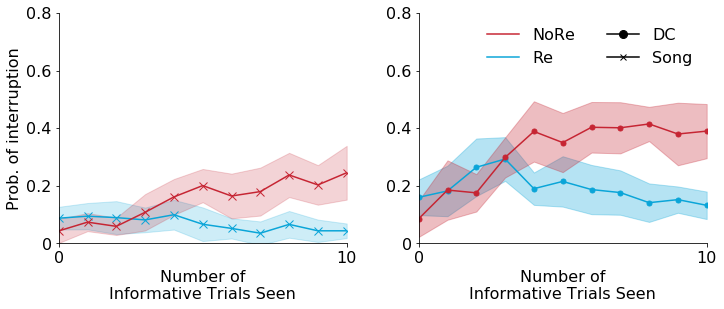

In [427]:
ncm_trials_new = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet1") &
    (trial_data["Treatment"] == "NCM")
]

fig, df1, df2 = plot_learning_curves_side_by_side(
    ncm_trials_new[ncm_trials_new["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    ncm_trials_new[ncm_trials_new["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(11),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-NCM-recall-lim10.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

ncm_trials_original = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Treatment"] == "NCM")
]
fig, df1, df2 = plot_learning_curves_side_by_side(
    ncm_trials_original[ncm_trials_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    ncm_trials_original[ncm_trials_original["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(11),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-NCM-prelesion-lim10.svg"), format="svg", bbox_inches="tight")

plt.show()


plt.close(fig)

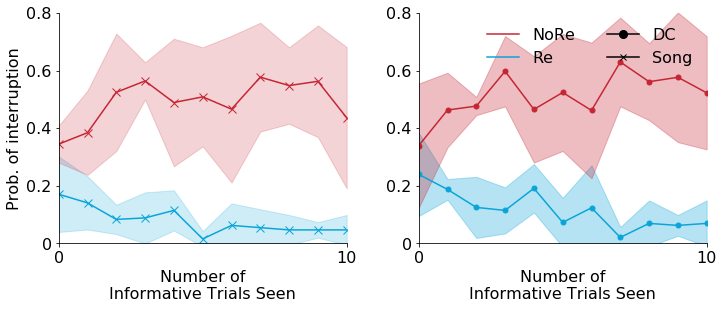

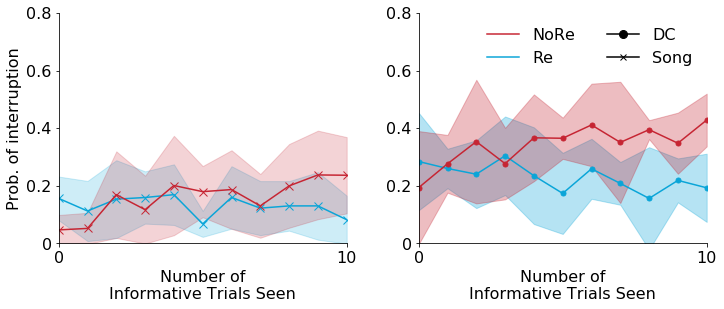

In [428]:

ctrl_trials_new = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet1") &
    (trial_data["Treatment"] == "CTRL")
]

fig, df1, df2 = plot_learning_curves_side_by_side(
    ctrl_trials_new[ctrl_trials_new["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    ctrl_trials_new[ctrl_trials_new["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(11),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-CTRL-recall-lim10.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

ctrl_trials_original = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Treatment"] == "CTRL")
]
fig, df1, df2 = plot_learning_curves_side_by_side(
    ctrl_trials_original[ctrl_trials_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    ctrl_trials_original[ctrl_trials_original["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(11),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-CTRL-prelesion-lim10.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

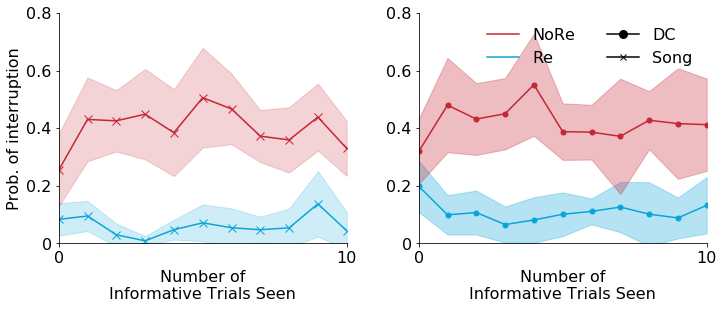

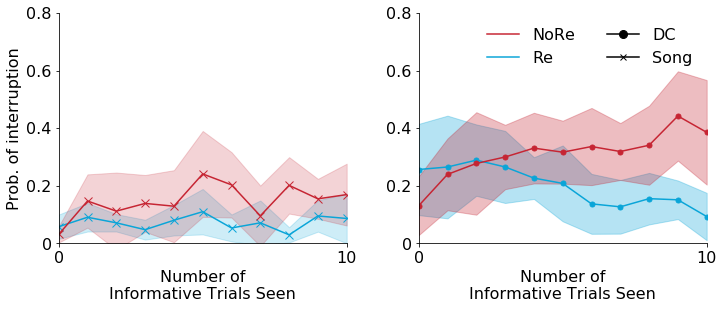

In [429]:

hvc_trials_new = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet1") &
    (trial_data["Treatment"] == "HVC")
]

fig, df1, df2 = plot_learning_curves_side_by_side(
    hvc_trials_new[hvc_trials_new["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    hvc_trials_new[hvc_trials_new["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(11),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-HVC-recall-lim10.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

hvc_trials_original = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Treatment"] == "HVC")
]
fig, df1, df2 = plot_learning_curves_side_by_side(
    hvc_trials_original[hvc_trials_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    hvc_trials_original[hvc_trials_original["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(11),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-HVC-prelesion-lim10.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

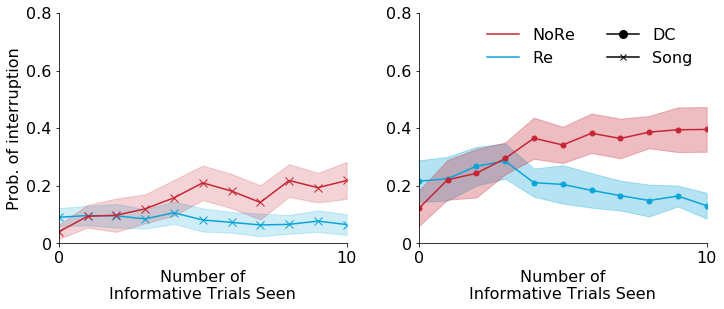

In [430]:

all_original = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1")
]
fig, df1, df2 = plot_learning_curves_side_by_side(
    all_original[all_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    all_original[all_original["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(11),
    ylim=(0, 0.8)
)
fig.savefig("../notebooks/figures/fig_learning_ctrlhvc_group_s1.svg", format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")
fig.savefig(savedir("learning_curve-ALL-prelesion-lim10.svg"), format="svg", bbox_inches="tight")

plt.close(fig)

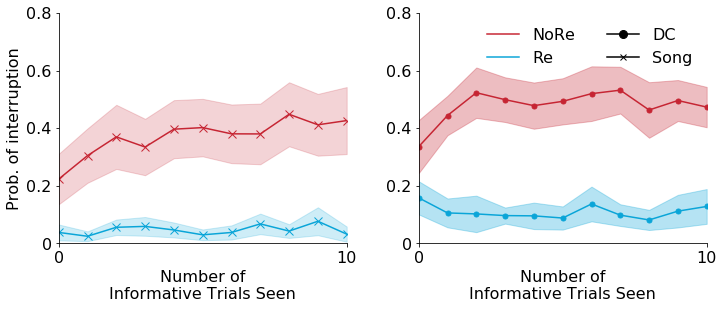

In [431]:
all_original_late = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1")
]
fig, df1, df2 = plot_learning_curves_side_by_side(
    all_original_late[all_original_late["Test Context"].isin(["SovsSo_8v8_d2"])],
    all_original_late[all_original_late["Test Context"].isin(["DCvsDC_6v6_d2"])],
    informative_trials=np.arange(11),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-ALL-prelesion_learned-lim10.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

### Since the curves for song and DC look so similar, lets try to combine them

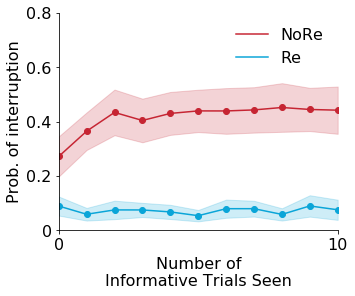

In [432]:
all_original_late = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1")
]
fig, df1 = plot_learning_curves_one(
    all_original_late[all_original_late["Test Context"].isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(11),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-ALL-SONGANDDC-prelesion_learned-lim10.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

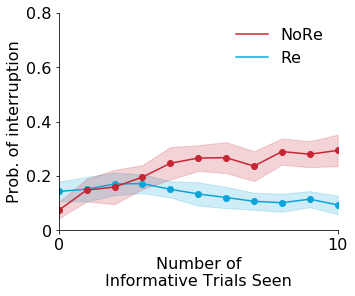

In [433]:
all_original_late = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1")
]
fig, df1 = plot_learning_curves_one(
    all_original[all_original["Test Context"].isin([
        "SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2",
        "DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"]
    )],
    informative_trials=np.arange(11),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-ALL-SONGANDDC-prelesion-lim10.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

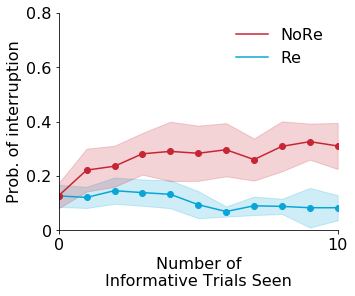

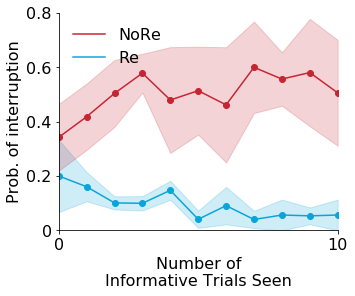

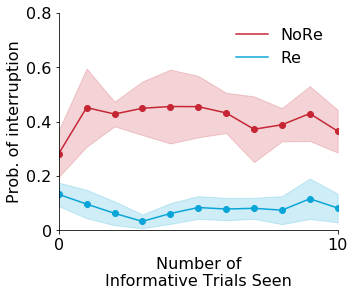

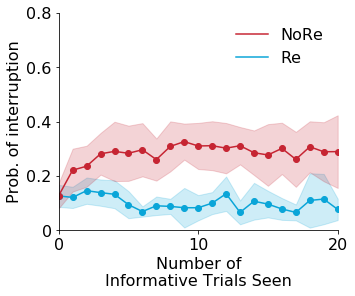

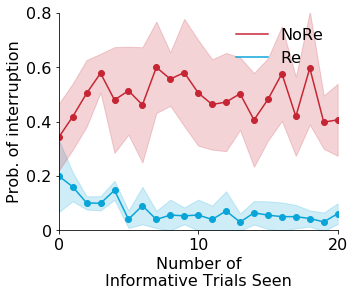

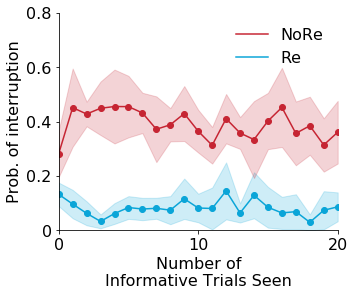

In [639]:
for lim in [11, 21]:
    ncm_trials_new = trial_data[
        (trial_data["Ladder Group"] == "PostlesionSet1") &
        (trial_data["Treatment"] == "NCM")
    ]

    fig, df1 = plot_learning_curves_one(
        ncm_trials_new[ncm_trials_new["Test Context"].isin([
            "SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2",  # The 4v4 and 8v8_d1 doesnt actually exist here
            "DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"
        ])],
        informative_trials=np.arange(lim),
        ylim=(0, 0.8)
    )
    fig.savefig(savedir("learning_curve-NCM-SONGANDDC-recall-lim{}.svg".format(lim - 1)), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)


    ctrl_trials_new = trial_data[
        (trial_data["Ladder Group"] == "PostlesionSet1") &
        (trial_data["Treatment"] == "CTRL")
    ]
    fig, df1 = plot_learning_curves_one(
        ctrl_trials_new[ctrl_trials_new["Test Context"].isin([
            "SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2",
            "DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"
        ])],
        informative_trials=np.arange(lim),
        ylim=(0, 0.8)
    )
    fig.savefig(savedir("learning_curve-CTRL-SONGANDDC-recall-lim{}.svg".format(lim - 1)), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)

    hvc_trials_new = trial_data[
        (trial_data["Ladder Group"] == "PostlesionSet1") &
        (trial_data["Treatment"] == "HVC")
    ]

    fig, df1 = plot_learning_curves_one(
        hvc_trials_new[hvc_trials_new["Test Context"].isin([
            "SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2",
            "DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"
        ])],
        informative_trials=np.arange(lim),
        ylim=(0, 0.8)
    )
    fig.savefig(savedir("learning_curve-HVC-SONGANDDC-recall-lim{}.svg".format(lim - 1)), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)


Significance test (False discovery rate): [False  True  True  True  True  True  True  True  True  True  True]
Significance test (False discovery rate): [ True  True  True  True  True  True  True  True  True  True  True]
Significance test (False discovery rate): [False  True  True  True  True  True  True  True  True  True  True]


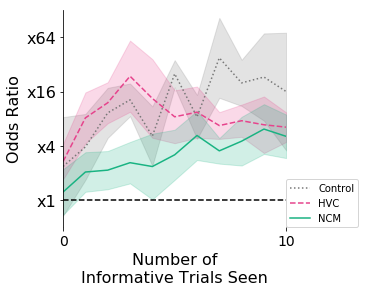

Significance test (False discovery rate): [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Significance test (False discovery rate): [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Significance test (False discovery rate): [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


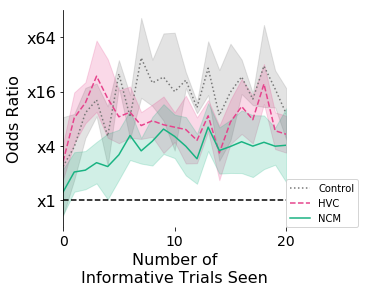

In [640]:

for lim in [11, 21]:
    fig = plt.figure(figsize=(4, 4))
    ax = plt.gca()

    so_result_df = plot_learning_curve_2(
        ctrl_trials_new[ctrl_trials_new["Test Context"].isin([
            "SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2",
            "DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"
        ])],
        np.arange(lim),
        ax,
        fill_kwargs=dict(
            color=CTRL_COLOR,
            alpha=0.2,
            zorder=-2,
        ),
        line_kwargs = dict(
            color=CTRL_COLOR,
            marker=None,
            linestyle=":",
            markersize=8,
            zorder=-1,
            label="Control",
        )
    )
    print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

    so_result_df = plot_learning_curve_2(
        hvc_trials_new[hvc_trials_new["Test Context"].isin([
            "SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2",
            "DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"
        ])],
        np.arange(lim),
        ax,
        fill_kwargs=dict(
            color=HVC_COLOR,
            alpha=0.2,
            zorder=-2,
        ),
        line_kwargs = dict(
            color=HVC_COLOR,
            marker=None,
            linestyle="--",
            markersize=8,
            zorder=-1,
            label="HVC"
        )
    )
    print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

    so_result_df = plot_learning_curve_2(
        ncm_trials_new[ncm_trials_new["Test Context"].isin([
            "SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2",  # The 4v4 and 8v8_d1 doesnt actually exist here
            "DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"
        ])],
        np.arange(lim),
        ax,
        fill_kwargs=dict(
            color=NCM_COLOR,
            alpha=0.2,
            zorder=-1,
        ),
        line_kwargs = dict(
            color=NCM_COLOR,
            marker=None,
            markersize=8,
            label="NCM",
        )
    )

    print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    # Set limits and axes of plot
    ax.set_xlim(0, lim-1)
    ax.set_xticks(np.arange(0, lim, 10))
    ax.set_xticklabels(np.arange(0, lim, 10).astype(int), fontsize=AXIS_SIZE)
    ax.set_yticks([-1, 0, 1, 2, 3])
    ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=AXIS_SIZE)
    ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

    ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
    set_oddsratio_yticks(ax, biggest=7, smallest=-2, convert_log=False)
    ax.set_ylim(-1.0, 7)
    ax.set_ylabel(r"Odds Ratio", fontsize=LABEL_SIZE)# , rotation=0, horizontalalignment="right")
    plt.legend(loc=(1, 0))

    plt.show()
    fig.savefig(savedir("learning_curve_oddsratio-ALL-SONGANDDC-recall-lim{}.svg".format(lim - 1)), format="svg", bbox_inches="tight")
    plt.close(fig)


Significance test (False discovery rate): [False False False False  True  True  True  True  True  True  True]


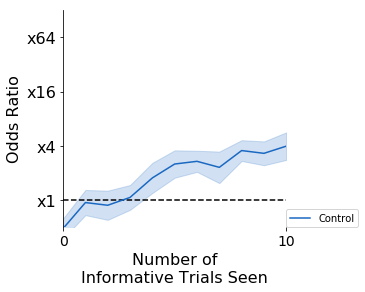

Significance test (False discovery rate): [False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


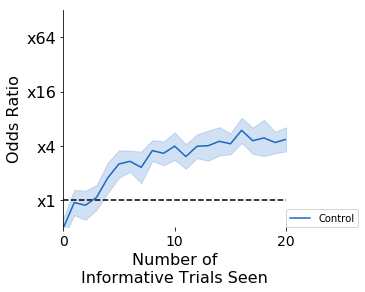

In [641]:
for lim in [11, 21]:
    fig = plt.figure(figsize=(4, 4))
    ax = plt.gca()

    so_result_df = plot_learning_curve_2(
        trial_data[
            (trial_data["Ladder Group"] == "PrelesionSet1")
        ],
        np.arange(lim),
        ax,
        fill_kwargs=dict(
            color=NEUTRAL_COLOR,
            alpha=0.2,
            zorder=-2,
        ),
        line_kwargs = dict(
            color=NEUTRAL_COLOR,
            marker=None,
            linestyle="-",
            markersize=8,
            zorder=-1,
            label="Control",
        )
    )
    print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    # Set limits and axes of plot
    ax.set_xlim(0, lim-1)
    ax.set_xticks(np.arange(0, lim, 10))
    ax.set_xticklabels(np.arange(0, lim, 10).astype(int), fontsize=AXIS_SIZE)
    ax.set_yticks([-1, 0, 1, 2, 3])
    ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=AXIS_SIZE)
    ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

    ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
    set_oddsratio_yticks(ax, biggest=7, smallest=-2, convert_log=False)
    ax.set_ylim(-1.0, 7)
    ax.set_ylabel(r"Odds Ratio", fontsize=LABEL_SIZE)# , rotation=0, horizontalalignment="right")
    plt.legend(loc=(1, 0))

    plt.show()
    fig.savefig(savedir("learning_curve_oddsratio-ALL-SONGANDDC-prelesion_learning-lim{}.svg".format(lim - 1)), format="svg", bbox_inches="tight")
    plt.close(fig)

    


Significance test (False discovery rate): [ True  True  True  True  True  True  True  True  True  True  True]


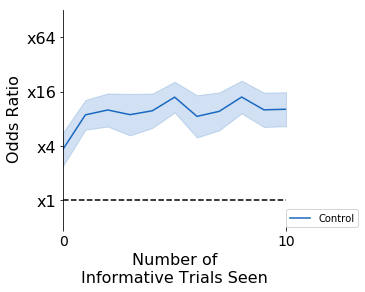

Significance test (False discovery rate): [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False]


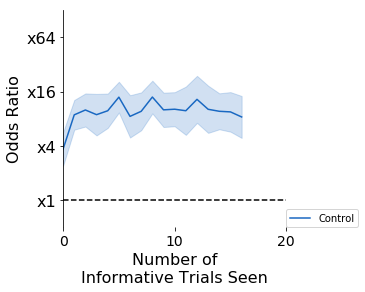

In [642]:
for lim in [11, 21]:
    fig = plt.figure(figsize=(4, 4))
    ax = plt.gca()

    so_result_df = plot_learning_curve_2(
        trial_data[
            (trial_data["Ladder Group"] == "PrelesionSet1") & 
            (trial_data["Test Context"].isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"]))
        ],
        np.arange(lim),
        ax,
        fill_kwargs=dict(
            color=NEUTRAL_COLOR,
            alpha=0.2,
            zorder=-2,
        ),
        line_kwargs = dict(
            color=NEUTRAL_COLOR,
            marker=None,
            linestyle="-",
            markersize=8,
            zorder=-1,
            label="Control",
        )
    )
    print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    # Set limits and axes of plot
    ax.set_xlim(0, lim-1)
    ax.set_xticks(np.arange(0, lim, 10))
    ax.set_xticklabels(np.arange(0, lim, 10).astype(int), fontsize=AXIS_SIZE)
    ax.set_yticks([-1, 0, 1, 2, 3])
    ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=AXIS_SIZE)
    ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

    ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
    set_oddsratio_yticks(ax, biggest=7, smallest=-2, convert_log=False)
    ax.set_ylim(-1.0, 7)
    ax.set_ylabel(r"Odds Ratio", fontsize=LABEL_SIZE)# , rotation=0, horizontalalignment="right")
    plt.legend(loc=(1, 0))

    plt.show()
    fig.savefig(savedir("learning_curve_oddsratio-ALL-SONGANDDC-prelesion_learned-lim{}.svg".format(lim - 1)), format="svg", bbox_inches="tight")
    plt.close(fig)

    


# Learning curves set 2 vs set 1

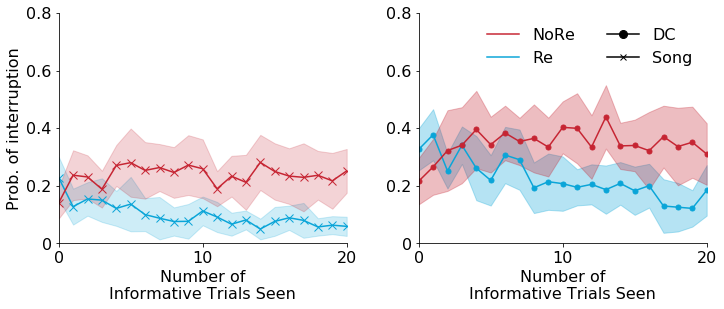

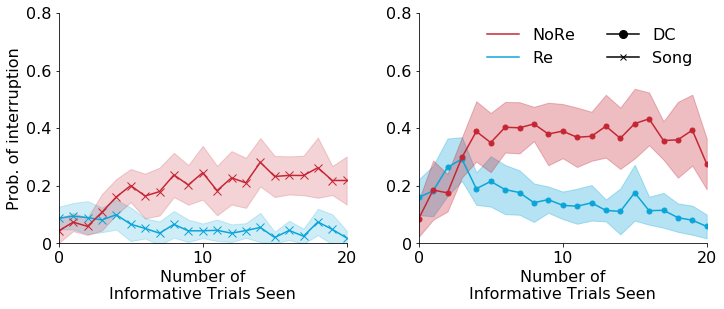

In [436]:

ncm_trials_new = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet2") &
    (trial_data["Treatment"] == "NCM")
]

fig, df1, df2 = plot_learning_curves_side_by_side(
    ncm_trials_new[ncm_trials_new["Test Context"].isin(["SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2"])],
    ncm_trials_new[ncm_trials_new["Test Context"].isin(["DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"])],
    informative_trials=np.arange(21),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-NCM-postlesion_learning-lim20.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

ncm_trials_original = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Treatment"] == "NCM")
]
fig, df1, df2 = plot_learning_curves_side_by_side(
    ncm_trials_original[ncm_trials_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    ncm_trials_original[ncm_trials_original["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(21),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-NCM-prelesion-lim20.svg"), format="svg", bbox_inches="tight")

plt.show()


plt.close(fig)

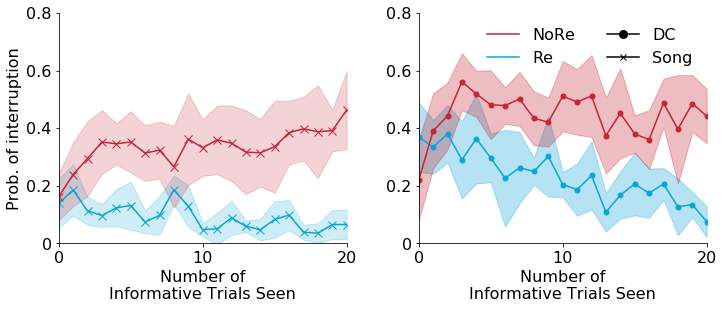

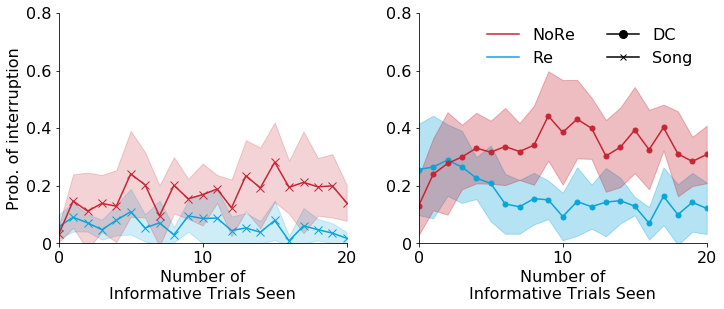

In [439]:

non_ncm_trials_new = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet2") &
    (trial_data["Treatment"] == "HVC")
]

fig, df1, df2 = plot_learning_curves_side_by_side(
    non_ncm_trials_new[non_ncm_trials_new["Test Context"].isin(["SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2"])],
    non_ncm_trials_new[non_ncm_trials_new["Test Context"].isin(["DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"])],
    informative_trials=np.arange(21),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-HVC-postlesion_learning-lim20.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

non_ncm_trials_original = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Treatment"] == "HVC")
]
fig, df1, df2 = plot_learning_curves_side_by_side(
    non_ncm_trials_original[non_ncm_trials_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    non_ncm_trials_original[non_ncm_trials_original["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(21),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-HVC-prelesion-lim20.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

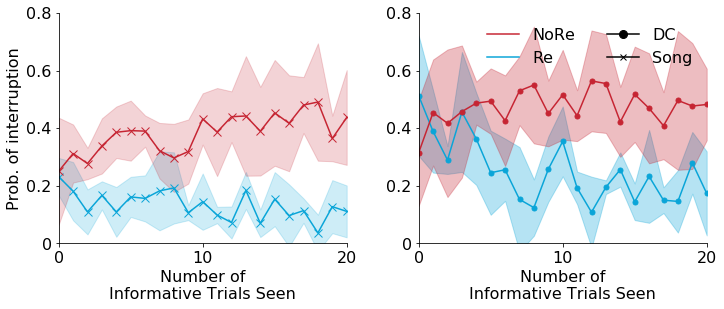

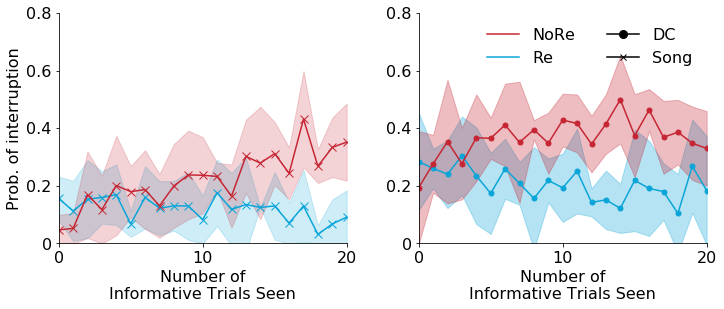

In [440]:

non_ncm_trials_new = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet2") &
    (trial_data["Treatment"] == "CTRL")
]

fig, df1, df2 = plot_learning_curves_side_by_side(
    non_ncm_trials_new[non_ncm_trials_new["Test Context"].isin(["SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2"])],
    non_ncm_trials_new[non_ncm_trials_new["Test Context"].isin(["DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"])],
    informative_trials=np.arange(21),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-CTRL-postlesion_learning-lim20.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

non_ncm_trials_original = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Treatment"] == "CTRL")
]
fig, df1, df2 = plot_learning_curves_side_by_side(
    non_ncm_trials_original[non_ncm_trials_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    non_ncm_trials_original[non_ncm_trials_original["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(21),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-CTRL-prelesion-lim20.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

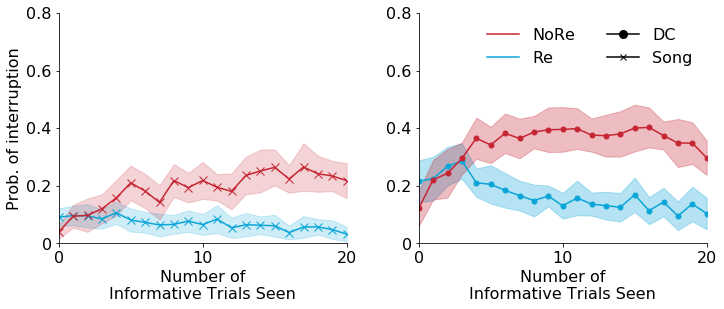

In [441]:
non_ncm_trials_original = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1")
]
fig, df1, df2 = plot_learning_curves_side_by_side(
    non_ncm_trials_original[non_ncm_trials_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    non_ncm_trials_original[non_ncm_trials_original["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(21),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-ALL-prelesion-lim20.svg"), format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

### Now the combined Song and DC plots

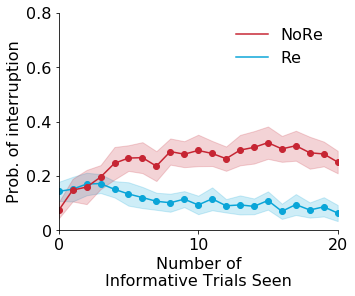

In [443]:
all_original_late = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1")
]
fig, df1 = plot_learning_curves_one(
    all_original[all_original["Test Context"].isin([
        "SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2",
        "DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"]
    )],
    informative_trials=np.arange(21),
    ylim=(0, 0.8)
)
fig.savefig(savedir("learning_curve-ALL-SONGANDDC-prelesion-lim20.svg"), format="svg", bbox_inches="tight")
plt.show()
plt.close(fig)

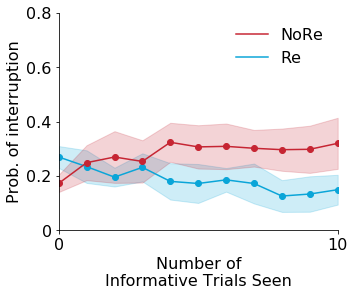

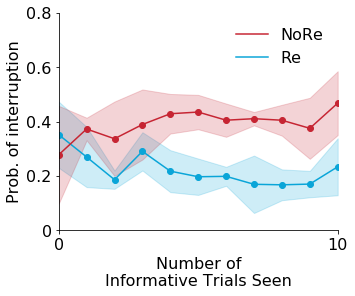

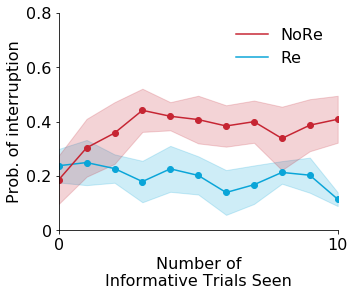

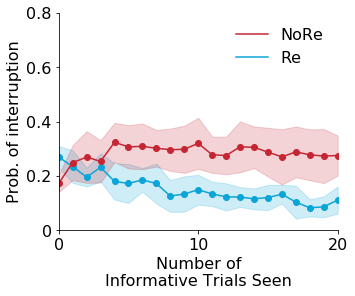

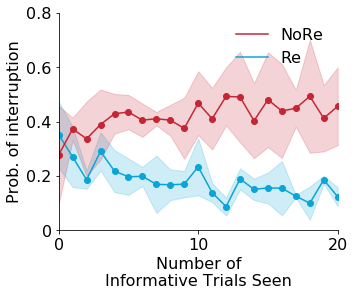

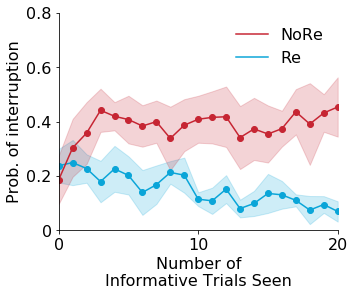

In [647]:
for lim in [11, 21]:
    ncm_trials_new = trial_data[
        (trial_data["Ladder Group"] == "PostlesionSet2") &
        (trial_data["Treatment"] == "NCM")
    ]

    fig, df1 = plot_learning_curves_one(
        ncm_trials_new[ncm_trials_new["Test Context"].isin([
            "SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2",  # The 4v4 and 8v8_d1 doesnt actually exist here
            "DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"
        ])],
        informative_trials=np.arange(lim),
        ylim=(0, 0.8)
    )
    fig.savefig(savedir("learning_curve-NCM-SONGANDDC-postlesion_learning-lim{}.svg".format(lim - 1)), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)


    ctrl_trials_new = trial_data[
        (trial_data["Ladder Group"] == "PostlesionSet2") &
        (trial_data["Treatment"] == "CTRL")
    ]
    fig, df1 = plot_learning_curves_one(
        ctrl_trials_new[ctrl_trials_new["Test Context"].isin([
            "SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2",  # The 4v4 and 8v8_d1 doesnt actually exist here
            "DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"
        ])],
        informative_trials=np.arange(lim),
        ylim=(0, 0.8)
    )
    fig.savefig(savedir("learning_curve-CTRL-SONGANDDC-postlesion_learning-lim{}.svg".format(lim - 1)), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)

    hvc_trials_new = trial_data[
        (trial_data["Ladder Group"] == "PostlesionSet2") &
        (trial_data["Treatment"] == "HVC")
    ]

    fig, df1 = plot_learning_curves_one(
        hvc_trials_new[hvc_trials_new["Test Context"].isin([
            "SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2",  # The 4v4 and 8v8_d1 doesnt actually exist here
            "DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"
        ])],
        informative_trials=np.arange(lim),
        ylim=(0, 0.8)
    )
    fig.savefig(savedir("learning_curve-HVC-SONGANDDC-postlesion_learning-lim{}.svg".format(lim - 1)), format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)


Significance test (False discovery rate): [False False False False  True  True  True False  True  True False]
Significance test (False discovery rate): [False False False  True  True  True  True  True False  True  True]
Significance test (False discovery rate): [False False False False  True  True  True  True  True  True  True]


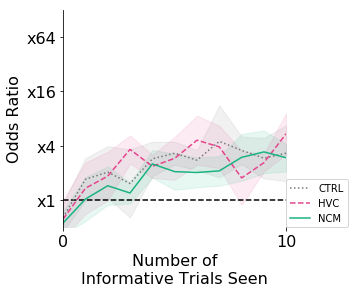

Significance test (False discovery rate): [False False False False  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True]
Significance test (False discovery rate): [False False False  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True]
Significance test (False discovery rate): [False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


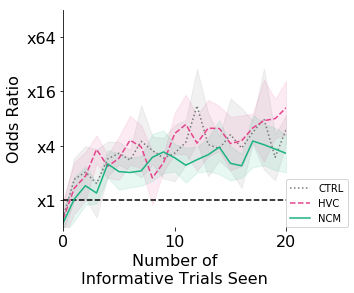

In [648]:

for lim in [11, 21]:
    fig = plt.figure(figsize=(4, 4))
    ax = plt.gca()

    so_result_df = plot_learning_curve_2(
        ctrl_trials_new[ctrl_trials_new["Test Context"].isin([
            "SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2",  # The 4v4 and 8v8_d1 doesnt actually exist here
            "DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"
        ])],
        np.arange(lim),
        ax,
        fill_kwargs=dict(
            color=CTRL_COLOR,
            alpha=0.1,
            zorder=-2,
        ),
        line_kwargs = dict(
            color=CTRL_COLOR,
            marker=None,
            linestyle=":",
            markersize=8,
            zorder=-1,
            label="CTRL",

        )
    )
    print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

    so_result_df = plot_learning_curve_2(
        hvc_trials_new[hvc_trials_new["Test Context"].isin([
            "SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2",  # The 4v4 and 8v8_d1 doesnt actually exist here
            "DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"
        ])],
        np.arange(lim),
        ax,
        fill_kwargs=dict(
            color=HVC_COLOR,
            alpha=0.1,
            zorder=-2,
        ),
        line_kwargs = dict(
            color=HVC_COLOR,
            marker=None,
            linestyle="--",
            markersize=8,
            zorder=-1,
            label="HVC",

        )
    )
    print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

    so_result_df = plot_learning_curve_2(
        ncm_trials_new[ncm_trials_new["Test Context"].isin([
            "SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2",  # The 4v4 and 8v8_d1 doesnt actually exist here
            "DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"
        ])],
        np.arange(lim),
        ax,
        fill_kwargs=dict(
            color=NCM_COLOR,
            alpha=0.1,
            zorder=-1,
        ),
        line_kwargs = dict(
            color=NCM_COLOR,
            marker=None,
            markersize=8,
            label="NCM",
        )
    )

    print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    # Set limits and axes of plot
    ax.set_xlim(0, lim-1)
    ax.set_xticks(np.arange(0, lim, 10))
    ax.set_xticklabels(np.arange(0, lim, 10).astype(int), fontsize=LABEL_SIZE)
    ax.set_yticks([-1, 0, 1, 2, 3])
    ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=LABEL_SIZE)
    ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

    ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
#     set_oddsratio_yticks(ax, biggest=6, smallest=-2, convert_log=False)
#     ax.set_ylim(-1.0, 5)
    
    set_oddsratio_yticks(ax, biggest=7, smallest=-2, convert_log=False)
    ax.set_ylim(-1.0, 7)

    ax.set_ylabel(r"Odds Ratio", fontsize=LABEL_SIZE)# , rotation=0, horizontalalignment="right")
    plt.legend(loc=(1, 0))

    plt.show()
    fig.savefig(savedir("learning_curve_oddsratio-ALL-SONGANDDC-new_set-lim{}.svg".format(lim - 1)), format="svg", bbox_inches="tight")

    plt.close(fig)


In [ ]:
color_by_call = {
    "SO": "#a834eb",
    "DC": "#73a2ff",
}

print("Song")
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

so_result_df = plot_learning_curve_2(
    non_ncm_trials_original[non_ncm_trials_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2", "DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color="Grey",
        alpha=0.2,
        zorder=-2,
    ),
    line_kwargs = dict(
        color="Grey",
        marker="x",
        markersize=8,
        zorder=-1,
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))


so_result_df = plot_learning_curve_2(
    all_original_late[all_original_late["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2", "DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color="Grey",
        alpha=0.2,
        zorder=-2,
    ),
    line_kwargs = dict(
        color="Grey",
        marker="x",
        markersize=8,
        zorder=-1,
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Set limits and axes of plot
ax.set_xlim(0, 20)
ax.set_xticks([0, 10, 20])
ax.set_xticklabels([0, 10, 20], fontsize=16)
ax.set_yticks([-1, 0, 1, 2, 3])
ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=16)
ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
set_oddsratio_yticks(ax, biggest=4, smallest=-2, convert_log=False)
ax.set_ylim(-1.0, 4)
ax.set_ylabel(r"Odds Ratio", fontsize=14)# , rotation=0, horizontalalignment="right")
plt.legend()


Song
Significance test (False discovery rate): [False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


In [320]:
def group_by_subject(df, informative_trials):
    """
    Collect probability of interruption across subjects in each informative trial bin
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    inform_df = generate_informative_trial_dataframe(df, informative_trials)

    # If a subject interrupted all trials or did not interrupt at all within
    # one bin, we want to replace that by a generic interruption probability.
    # We will use 1/2 the average probability of interruption within that bin
    # across all subjects.
    baselines = inform_df.groupby([
        "Relative Informative Trials Seen", "Stimulus Class"
    ]).mean()["p(interrupt)"]

    # Generate a dataframe with the log odds of interruption for Rewarded
    # and Nonrewarded trials for each subject in each informative trial bin.
    binned = inform_df.groupby(
        ["Relative Informative Trials Seen", "Subject"],
    )
    by_subject_rows = []
    for (bin_idx, subject), subdf in binned:
        baseline_p_rew = baselines.loc[bin_idx, "Rewarded"] / 2
        baseline_p_norew = baselines.loc[bin_idx, "Nonrewarded"] / 2

        rew = subdf[subdf["Stimulus Class"] == "Rewarded"]
        norew = subdf[subdf["Stimulus Class"] == "Nonrewarded"]
        
        p_rew = np.mean(rew["p(interrupt)"])
        p_norew = np.mean(norew["p(interrupt)"])
        p_rew = p_rew or baseline_p_rew
        p_norew = p_norew or baseline_p_norew
        
        norew_logodds = np.log2(p_norew / (1 - p_norew))
        rew_logodds = np.log2(p_rew / (1 - p_rew))
        
        by_subject_rows.append({
            "Log(OR)": norew_logodds - rew_logodds,
            "Subject": subject,
            "Rewarded Log Odds": rew_logodds,
            "Nonrewarded Log Odds": norew_logodds,
            "Relative Informative Trials Seen": bin_idx
        })
    by_subject_df = pd.DataFrame(by_subject_rows)
    
    return by_subject_df


def summarize_across_subjects(grouped_df):
    result_rows = []
    for bin_idx, subdf in grouped_df.groupby("Relative Informative Trials Seen"):
        # Stats
        # Run a paried t test in each bin to test if p_unrew > p_re
        t_stat, p_val = ttest_rel(subdf["Nonrewarded Log Odds"], subdf["Rewarded Log Odds"])
        p_val = p_val / 2
        
        mean, sem = jackknife(subdf["Log(OR)"], np.mean)
        result_rows.append({
            "Relative Informative Trials Seen": bin_idx,
            "Log(OR)": mean,
            "SEM": sem,
            "p-value": p_val if t_stat > 0 else 1.0
        })

    
    result_df = pd.DataFrame(result_rows)
    
    return result_df


def plot_learning_curve_2(df, informative_trials, ax, fill_kwargs, n_sem=2, line_kwargs=None):
    """
    Plot the learning curve across subjects for the given trials
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    learning_df = group_by_subject(df, informative_trials)
    result_df = summarize_across_subjects(learning_df).sort_values("Relative Informative Trials Seen")
    
    ax.fill_between(
        result_df["Relative Informative Trials Seen"],
        result_df["Log(OR)"] - 2 * result_df["SEM"],
        result_df["Log(OR)"] + 2 * result_df["SEM"],
        **fill_kwargs
    )
    
    ax.plot(
        result_df["Relative Informative Trials Seen"],
        result_df["Log(OR)"],
        **line_kwargs
    )
    
    return result_df

Song
Significance test (False discovery rate): [False False False False  True  True  True False False False  True  True
  True False  True False False  True  True False False]
Significance test (False discovery rate): [False False False False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


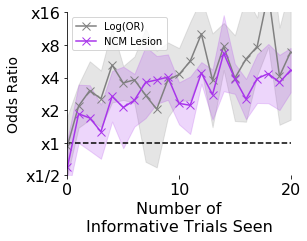

DC
Significance test (False discovery rate): [False False False False False  True  True False  True False False  True
 False  True  True False False  True False False  True]
Significance test (False discovery rate): [False False False False False False False False False  True  True  True
 False  True  True False False  True  True  True False]


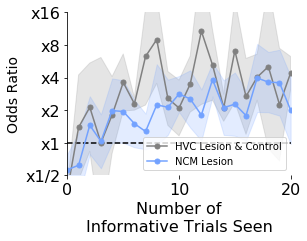

In [321]:
color_by_call = {
    "SO": "#a834eb",
    "DC": "#73a2ff",
}

print("Song")
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

so_result_df = plot_learning_curve_2(
    non_ncm_trials_new[non_ncm_trials_new["Test Context"].isin(["SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color="Grey",
        alpha=0.2,
        zorder=-2,
    ),
    line_kwargs = dict(
        color="Grey",
        marker="x",
        markersize=8,
        zorder=-1,
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))


so_result_df = plot_learning_curve_2(
    ncm_trials_new[ncm_trials_new["Test Context"].isin(["SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color=color_by_call.get("SO"),
        alpha=0.2,
        zorder=-1,
    ),
    line_kwargs = dict(
        color=color_by_call.get("SO"),
        marker="x",
        markersize=8,
        label="NCM Lesion",
    )
)

print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Set limits and axes of plot
ax.set_xlim(0, 20)
ax.set_xticks([0, 10, 20])
ax.set_xticklabels([0, 10, 20], fontsize=16)
ax.set_yticks([-1, 0, 1, 2, 3])
ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=16)
ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
set_oddsratio_yticks(ax, biggest=4, smallest=-2, convert_log=False)
ax.set_ylim(-1.0, 4)
ax.set_ylabel(r"Odds Ratio", fontsize=14)# , rotation=0, horizontalalignment="right")
plt.legend()
fig.savefig("../notebooks/figures/fig6a_learning_s2_song.svg", format="svg", bbox_inches="tight")

plt.show()
fig.savefig("")

plt.close(fig)

print("DC")
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()
dc_result_df = plot_learning_curve_2(
    non_ncm_trials_new[non_ncm_trials_new["Test Context"].isin(["DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color="Grey",
        alpha=0.2,
        zorder=-2,
    ),
    line_kwargs = dict(
        color="Grey",
        marker="o",
        markersize=5,
        zorder=-1,
        label="HVC Lesion & Control"
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(dc_result_df["p-value"])))


dc_result_df = plot_learning_curve_2(
    ncm_trials_new[ncm_trials_new["Test Context"].isin(["DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color=color_by_call.get("DC"),
        alpha=0.2,
        zorder=-1,
    ),
    line_kwargs = dict(
        color=color_by_call.get("DC"),
        marker="o",
        markersize=5,
        label="NCM Lesion",
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(dc_result_df["p-value"])))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Set limits and axes of plot
ax.set_xlim(0, 20)
ax.set_xticks([0, 10, 20])
ax.set_xticklabels([0, 10, 20], fontsize=16)
ax.set_yticks([-1, 0, 1, 2, 3])
ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=16)
ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
set_oddsratio_yticks(ax, biggest=4, smallest=-2, convert_log=False)
ax.set_ylim(-1.0, 4.0)
ax.set_ylabel(r"Odds Ratio", fontsize=14)# , rotation=0, horizontalalignment="right")
plt.legend()
fig.savefig("../notebooks/figures/fig6b_learning_s2_dc.svg", format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3CD_learning_curves_dc.svg", format="svg", bbox_inches="tight")
plt.close(fig)



Song
Significance test (False discovery rate): [False False  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True]
Significance test (False discovery rate): [False False False False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


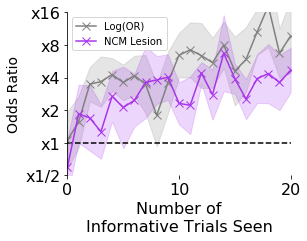

DC
Significance test (False discovery rate): [False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Significance test (False discovery rate): [False False False False False False False False False  True  True  True
 False  True  True False False  True  True  True False]


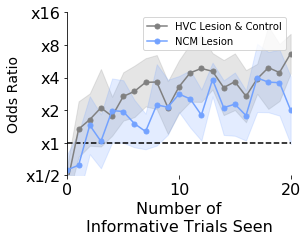

In [72]:
color_by_call = {
    "SO": "#a834eb",
    "DC": "#73a2ff",
}

print("Song")
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

so_result_df = plot_learning_curve_2(
    non_ncm_trials_new[non_ncm_trials_new["Test Context"].isin(["SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color="Grey",
        alpha=0.2,
        zorder=-2,
    ),
    line_kwargs = dict(
        color="Grey",
        marker="x",
        markersize=8,
        zorder=-1,
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))


so_result_df = plot_learning_curve_2(
    ncm_trials_new[ncm_trials_new["Test Context"].isin(["SovsSo_1v1_S2", "SovsSo_4v4_S2", "SovsSo_8v8_d1_S2", "SovsSo_8v8_d2_S2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color=color_by_call.get("SO"),
        alpha=0.2,
        zorder=-1,
    ),
    line_kwargs = dict(
        color=color_by_call.get("SO"),
        marker="x",
        markersize=8,
        label="NCM Lesion",
    )
)

print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Set limits and axes of plot
ax.set_xlim(0, 20)
ax.set_xticks([0, 10, 20])
ax.set_xticklabels([0, 10, 20], fontsize=16)
ax.set_yticks([-1, 0, 1, 2, 3])
ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=16)
ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
set_oddsratio_yticks(ax, biggest=4, smallest=-2, convert_log=False)
ax.set_ylim(-1.0, 4)
ax.set_ylabel(r"Odds Ratio", fontsize=14)# , rotation=0, horizontalalignment="right")
plt.legend()
fig.savefig("../notebooks/figures/fig6a_learning_s2_song.svg", format="svg", bbox_inches="tight")

plt.show()
fig.savefig("")

plt.close(fig)

print("DC")
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()
dc_result_df = plot_learning_curve_2(
    non_ncm_trials_new[non_ncm_trials_new["Test Context"].isin(["DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color="Grey",
        alpha=0.2,
        zorder=-2,
    ),
    line_kwargs = dict(
        color="Grey",
        marker="o",
        markersize=5,
        zorder=-1,
        label="HVC Lesion & Control"
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(dc_result_df["p-value"])))


dc_result_df = plot_learning_curve_2(
    ncm_trials_new[ncm_trials_new["Test Context"].isin(["DCvsDC_1v1_S2", "DCvsDC_4v4_S2", "DCvsDC_6v6_d1_S2", "DCvsDC_6v6_d2_S2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color=color_by_call.get("DC"),
        alpha=0.2,
        zorder=-1,
    ),
    line_kwargs = dict(
        color=color_by_call.get("DC"),
        marker="o",
        markersize=5,
        label="NCM Lesion",
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(dc_result_df["p-value"])))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Set limits and axes of plot
ax.set_xlim(0, 20)
ax.set_xticks([0, 10, 20])
ax.set_xticklabels([0, 10, 20], fontsize=16)
ax.set_yticks([-1, 0, 1, 2, 3])
ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=16)
ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
set_oddsratio_yticks(ax, biggest=4, smallest=-2, convert_log=False)
ax.set_ylim(-1.0, 4.0)
ax.set_ylabel(r"Odds Ratio", fontsize=14)# , rotation=0, horizontalalignment="right")
plt.legend()
fig.savefig("../notebooks/figures/fig6b_learning_s2_dc.svg", format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3CD_learning_curves_dc.svg", format="svg", bbox_inches="tight")
plt.close(fig)



Song
Significance test (False discovery rate): [False False False  True False  True  True False  True False  True  True
  True  True  True  True  True  True  True  True  True]
Significance test (False discovery rate): [False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


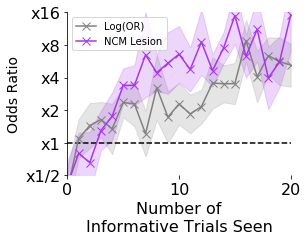

DC
Significance test (False discovery rate): [False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Significance test (False discovery rate): [False False False False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


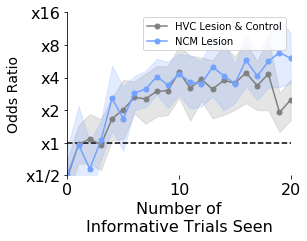

In [73]:
color_by_call = {
    "SO": "#a834eb",
    "DC": "#73a2ff",
}

print("Song")
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()
so_result_df = plot_learning_curve_2(
    non_ncm_trials_original[non_ncm_trials_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color="Grey",
        alpha=0.2,
        zorder=-2,
    ),
    line_kwargs = dict(
        color="Grey",
        marker="x",
        markersize=8,
        zorder=-1
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

so_result_df = plot_learning_curve_2(
    ncm_trials_original[ncm_trials_original["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color=color_by_call.get("SO"),
        alpha=0.2,
        zorder=-1,
    ),
    line_kwargs = dict(
        color=color_by_call.get("SO"),
        marker="x",
        markersize=8,
        label="NCM Lesion"
    )
)

print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Set limits and axes of plot
ax.set_xlim(0, 20)
ax.set_xticks([0, 10, 20])
ax.set_xticklabels([0, 10, 20], fontsize=16)
ax.set_yticks([-1, 0, 1, 2, 3])
ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=16)
ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
set_oddsratio_yticks(ax, biggest=4, smallest=-2, convert_log=False)
ax.set_ylim(-1.0, 4)
ax.set_ylabel(r"Odds Ratio", fontsize=14)# , rotation=0, horizontalalignment="right")
plt.legend()
fig.savefig("../notebooks/figures/fig6c_learning_s1_song.svg", format="svg", bbox_inches="tight")

plt.show()
# fig.savefig("figures/3CD_learning_curves_song.svg", format="svg", bbox_inches="tight")

plt.close(fig)

print("DC")
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()
dc_result_df = plot_learning_curve_2(
    non_ncm_trials_original[non_ncm_trials_original["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color="Grey",
        alpha=0.2,
        zorder=-2,
    ),
    line_kwargs = dict(
        color="Grey",
        marker="o",
        markersize=5,
        zorder=-1,
        label="HVC Lesion & Control"
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(dc_result_df["p-value"])))

dc_result_df = plot_learning_curve_2(
    ncm_trials_original[ncm_trials_original["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    np.arange(21),
    ax,
    fill_kwargs=dict(
        color=color_by_call.get("DC"),
        alpha=0.2,
        zorder=-1,
    ),
    line_kwargs = dict(
        color=color_by_call.get("DC"),
        marker="o",
        markersize=5,
        label="NCM Lesion"
    )
)


print("Significance test (False discovery rate): {}".format(false_discovery(dc_result_df["p-value"])))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Set limits and axes of plot
ax.set_xlim(0, 20)
ax.set_xticks([0, 10, 20])
ax.set_xticklabels([0, 10, 20], fontsize=16)
ax.set_yticks([-1, 0, 1, 2, 3])
ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=16)
ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
set_oddsratio_yticks(ax, biggest=4, smallest=-2, convert_log=False)
ax.set_ylim(-1.0, 4.0)
ax.set_ylabel(r"Odds Ratio", fontsize=14)# , rotation=0, horizontalalignment="right")
plt.legend()

fig.savefig("../notebooks/figures/fig6d_learning_s1_dc.svg", format="svg", bbox_inches="tight")

plt.show()

# fig.savefig("figures/3CD_learning_curves_dc.svg", format="svg", bbox_inches="tight")
plt.close(fig)



In [74]:
np.unique(ncm_trials_new.Subject)

array(['BlaGre1349M', 'GraWhi4040F', 'GreBla3404M', 'GreBlu5039F',
       'HpiGre0651M', 'RedHpi0710F', 'WhiBlu5805F', 'XXXBlu0031M',
       'XXXHpi0038M', 'XXXOra0037F'], dtype=object)

# Finally: Rendition extrapolation?

In [604]:
from functools import partial
from collections import defaultdict
from stats import linreg


def find_first_trial_per_rendition(df):
    """For each subject and vocalizer/calltype in the dataframe
    
    Make a row for the trial representing the very first time that file was presented
    """
    df = df.copy()
    
    def clean_stimulus_file(file):
        if file[-2:] in ["_0", "_1", "_2", "_3"]:
            file = file[:-2]
        return file

    df["Stimulus File"] = df["Stimulus File"].apply(clean_stimulus_file)
    df["First Presentation of File"] = False
    df["kth Presentation of Vocalizer"] = np.nan

    stimulus_vocalizer_counts = defaultdict(int)
    for (subject, _, vocalizer, call_type), subdf in df.sort_values("Time").groupby([
                "Subject", "Stimulus File", "Stimulus Vocalizer", "Stimulus Call Type"
            ], sort=False):
        k = stimulus_vocalizer_counts[(subject, vocalizer, call_type)]
        subdf = subdf.sort_values("Time")
        df.loc[subdf.index[0], "First Presentation of File"] = True
        df.loc[subdf.index[0], "kth Presentation of Vocalizer"] = k
        stimulus_vocalizer_counts[(subject, vocalizer, call_type)] += 1
        
    result = df[df["First Presentation of File"] == True]
    return result


def collapse_first_trials_per_rendition(df):
    """Collapse the output of find_first_trial_per_rendition across vocalizers
    """
    df = find_first_trial_per_rendition(df)
    output_rows = []
    for (subject, kth_presentation, call_type, stimulus_class), subdf in df.groupby([
                "Subject", "kth Presentation of Vocalizer", "Stimulus Call Type", "Stimulus Class"
            ]):
        
        output_rows.append([
            subject,
            kth_presentation,
            call_type,
            stimulus_class,
            np.mean(subdf["Interrupt"])
        ])
    return pd.DataFrame(output_rows,
            columns=["Subject", "kth Presentation", "Call Type", "Class", "p(interrupt)"])


def group_by_kth_presentation(df):
    df = collapse_first_trials_per_rendition(df)
    
    output_rows = []
    for (kth_presentation, stimulus_class, call_type), subdf in df.groupby(["kth Presentation", "Class", "Call Type"]):
        
        p = subdf["p(interrupt)"]
        mean_p, sem = jackknife(p, np.mean)
        
        output_rows.append([
            kth_presentation,
            stimulus_class,
            call_type,
            mean_p,
            sem
        ])
    return pd.DataFrame(output_rows,
        columns=["kth Presentation", "Class", "Call Type", "p(interrupt)", "SEM"])

0.36709214458395667 0.28797866265695127 10 1
Song Rewarded R2 = 0.37 R2_adj = 0.29
0.9071596768807942 0.8955546364908935 10 1
Song Nonrewarded R2 = 0.91 R2_adj = 0.90


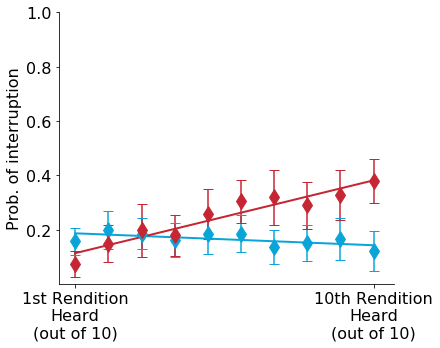

0.09324500692907356 -0.020099367204792218 10 1
DC Rewarded R2 = 0.09 R2_adj = -0.02
0.6619423473494872 0.6196851407681732 10 1
DC Nonrewarded R2 = 0.66 R2_adj = 0.62


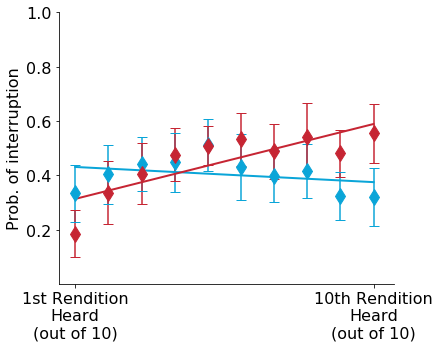

In [626]:
ncm_trials_new = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1")
#     (trial_data["Treatment"] == "NCM")
]
result = group_by_kth_presentation(ncm_trials_new)
fig = plt.figure(figsize=(6, 5))
rew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_song["kth Presentation"],
    rew_song["p(interrupt)"],
    yerr=2*rew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded")
)
norew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_song["kth Presentation"], 
    norew_song["p(interrupt)"],
    yerr=2*norew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded")
)

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_song["kth Presentation"], rew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_song["kth Presentation"], norew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Nonrewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 1.0)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4A_song_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)


fig = plt.figure(figsize=(6, 5))
rew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_dc["kth Presentation"],
    rew_dc["p(interrupt)"],
    yerr=2*rew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded"))
norew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_dc["kth Presentation"], 
    norew_dc["p(interrupt)"],
    yerr=2*norew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded"))

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_dc["kth Presentation"], rew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_dc["kth Presentation"], 
    lin(rew_dc["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_dc["kth Presentation"], norew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Nonrewarded", r_squared, r_adj))
plt.plot(
    norew_dc["kth Presentation"], 
    lin(norew_dc["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 1.0)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4B_dc_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)

0.5559734030957051 0.5004700784826682 10 1
Song Rewarded R2 = 0.56 R2_adj = 0.50
0.07870067582297824 -0.036461739699149565 10 1
Song Nonrewarded R2 = 0.08 R2_adj = -0.04


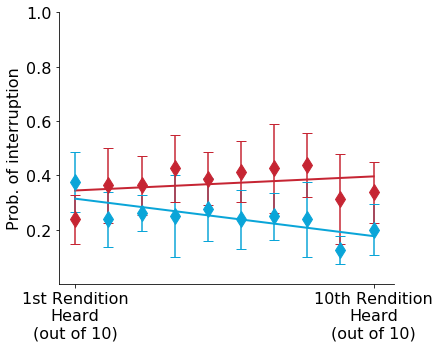

0.5808580858085826 0.5284653465346554 10 1
DC Rewarded R2 = 0.58 R2_adj = 0.53
0.8095759034387205 0.7857728913685607 10 1
DC Nonrewarded R2 = 0.81 R2_adj = 0.79


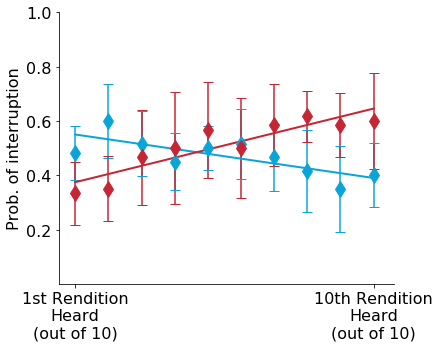

In [627]:
ncm_trials_new = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet2") &
    (trial_data["Treatment"] == "NCM")
]
result = group_by_kth_presentation(ncm_trials_new)

fig = plt.figure(figsize=(6, 5))
rew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_song["kth Presentation"],
    rew_song["p(interrupt)"],
    yerr=2*rew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded")
)
norew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_song["kth Presentation"], 
    norew_song["p(interrupt)"],
    yerr=2*norew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded")
)

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_song["kth Presentation"], rew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_song["kth Presentation"], norew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Nonrewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 1.0)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4A_song_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)


fig = plt.figure(figsize=(6, 5))
rew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_dc["kth Presentation"],
    rew_dc["p(interrupt)"],
    yerr=2*rew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded"))
norew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_dc["kth Presentation"], 
    norew_dc["p(interrupt)"],
    yerr=2*norew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded"))

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_dc["kth Presentation"], rew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_dc["kth Presentation"], 
    lin(rew_dc["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_dc["kth Presentation"], norew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Nonrewarded", r_squared, r_adj))
plt.plot(
    norew_dc["kth Presentation"], 
    lin(norew_dc["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 1.0)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4B_dc_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)

0.3830269453538132 0.30590531352303985 10 1
Song Rewarded R2 = 0.38 R2_adj = 0.31
0.10398745796975883 -0.008014109784021395 10 1
Song Nonrewarded R2 = 0.10 R2_adj = -0.01


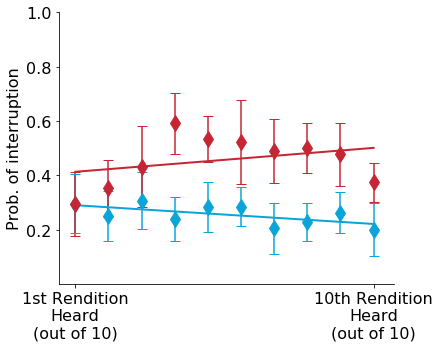

0.49165337586390256 0.42811004784689044 10 1
DC Rewarded R2 = 0.49 R2_adj = 0.43
0.8135798664612244 0.7902773497688774 10 1
DC Nonrewarded R2 = 0.81 R2_adj = 0.79


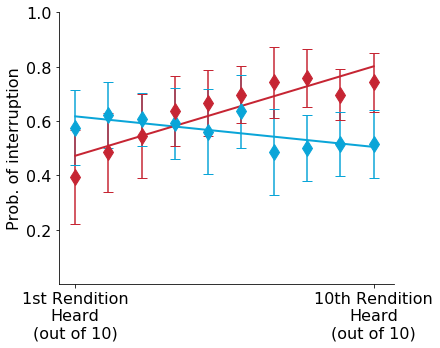

In [629]:
ncm_trials_new = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet2") &
    (trial_data["Treatment"] != "NCM")
]
result = group_by_kth_presentation(ncm_trials_new)

fig = plt.figure(figsize=(6, 5))
rew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_song["kth Presentation"],
    rew_song["p(interrupt)"],
    yerr=2*rew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded")
)
norew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_song["kth Presentation"], 
    norew_song["p(interrupt)"],
    yerr=2*norew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded")
)

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_song["kth Presentation"], rew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_song["kth Presentation"], norew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Nonrewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 1.0)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4A_song_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)


fig = plt.figure(figsize=(6, 5))
rew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_dc["kth Presentation"],
    rew_dc["p(interrupt)"],
    yerr=2*rew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded"))
norew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_dc["kth Presentation"], 
    norew_dc["p(interrupt)"],
    yerr=2*norew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded"))

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_dc["kth Presentation"], rew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_dc["kth Presentation"], 
    lin(rew_dc["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_dc["kth Presentation"], norew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Nonrewarded", r_squared, r_adj))
plt.plot(
    norew_dc["kth Presentation"], 
    lin(norew_dc["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 1.0)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4B_dc_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)

In [75]:
from functools import partial
from collections import defaultdict
from stats import linreg


def find_first_trial_per_rendition(df):
    """For each subject and vocalizer/calltype in the dataframe
    
    Make a row for the trial representing the very first time that file was presented
    """
    df = df.copy()
    
    def clean_stimulus_file(file):
        if file[-2:] in ["_0", "_1", "_2", "_3"]:
            file = file[:-2]
        return file

    df["Stimulus File"] = df["Stimulus File"].apply(clean_stimulus_file)
    df["First Presentation of File"] = False
    df["kth Presentation of Vocalizer"] = np.nan

    stimulus_vocalizer_counts = defaultdict(int)
    for (subject, _, vocalizer, call_type), subdf in df.sort_values("Time").groupby([
                "Subject", "Stimulus File", "Stimulus Vocalizer", "Stimulus Call Type"
            ], sort=False):
        k = stimulus_vocalizer_counts[(subject, vocalizer, call_type)]
        subdf = subdf.sort_values("Time")
        df.loc[subdf.index[0], "First Presentation of File"] = True
        df.loc[subdf.index[0], "kth Presentation of Vocalizer"] = k
        stimulus_vocalizer_counts[(subject, vocalizer, call_type)] += 1
        
    result = df[df["First Presentation of File"] == True]
    return result


def collapse_first_trials_per_rendition(df):
    """Collapse the output of find_first_trial_per_rendition across vocalizers
    """
    df = find_first_trial_per_rendition(df)
    output_rows = []
    for (subject, kth_presentation, call_type, stimulus_class), subdf in df.groupby([
                "Subject", "kth Presentation of Vocalizer", "Stimulus Call Type", "Stimulus Class"
            ]):
        
        output_rows.append([
            subject,
            kth_presentation,
            call_type,
            stimulus_class,
            np.mean(subdf["Interrupt"])
        ])
    return pd.DataFrame(output_rows,
            columns=["Subject", "kth Presentation", "Call Type", "Class", "p(interrupt)"])


def group_by_kth_presentation(df):
    df = collapse_first_trials_per_rendition(df)
    
    output_rows = []
    for (kth_presentation, stimulus_class, call_type), subdf in df.groupby(["kth Presentation", "Class", "Call Type"]):
        
        p = subdf["p(interrupt)"]
        mean_p, sem = jackknife(p, np.mean)
        
        output_rows.append([
            kth_presentation,
            stimulus_class,
            call_type,
            mean_p,
            sem
        ])
    return pd.DataFrame(output_rows,
        columns=["kth Presentation", "Class", "Call Type", "p(interrupt)", "SEM"])

In [605]:
result = group_by_kth_presentation(ncm_trials_original)

In [606]:
result

,kth Presentation,Class,Call Type,p(interrupt),SEM
0,0.0,Nonrewarded,DC,0.313333,0.053166
1,0.0,Nonrewarded,SO,0.128571,0.030702
2,0.0,Rewarded,DC,0.293333,0.070679
3,0.0,Rewarded,SO,0.155357,0.043452
4,1.0,Nonrewarded,DC,0.423333,0.097872
5,1.0,Nonrewarded,SO,0.308929,0.092342
6,1.0,Rewarded,DC,0.250000,0.058926
7,1.0,Rewarded,SO,0.182143,0.037948
8,2.0,Nonrewarded,DC,0.386667,0.096632
9,2.0,Nonrewarded,SO,0.435714,0.071214


Song Rewarded R2 = 0.58 R2_adj = 0.53
Song Nonrewarded R2 = 0.89 R2_adj = 0.87


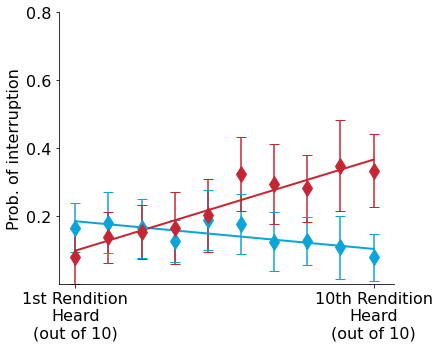

DC Rewarded R2 = 0.03 R2_adj = -0.09
DC Nonrewarded R2 = 0.67 R2_adj = 0.63


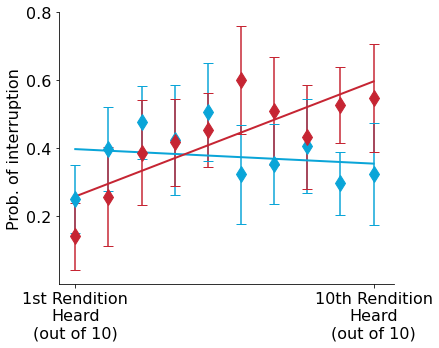

In [1122]:
fig = plt.figure(figsize=(6, 5))
rew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_song["kth Presentation"],
    rew_song["p(interrupt)"],
    yerr=2*rew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded")
)
norew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_song["kth Presentation"], 
    norew_song["p(interrupt)"],
    yerr=2*norew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded")
)

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_song["kth Presentation"], rew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_song["kth Presentation"], norew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Nonrewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4A_song_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)


fig = plt.figure(figsize=(6, 5))
rew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_dc["kth Presentation"],
    rew_dc["p(interrupt)"],
    yerr=2*rew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded"))
norew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_dc["kth Presentation"], 
    norew_dc["p(interrupt)"],
    yerr=2*norew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded"))

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_dc["kth Presentation"], rew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_dc["kth Presentation"], 
    lin(rew_dc["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_dc["kth Presentation"], norew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Nonrewarded", r_squared, r_adj))
plt.plot(
    norew_dc["kth Presentation"], 
    lin(norew_dc["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4B_dc_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)

In [1123]:
result = group_by_kth_presentation(ncm_trials_new)

Song Rewarded R2 = 0.56 R2_adj = 0.50
Song Nonrewarded R2 = 0.08 R2_adj = -0.04


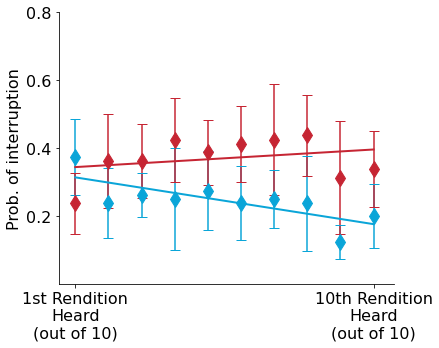

DC Rewarded R2 = 0.58 R2_adj = 0.53
DC Nonrewarded R2 = 0.81 R2_adj = 0.79


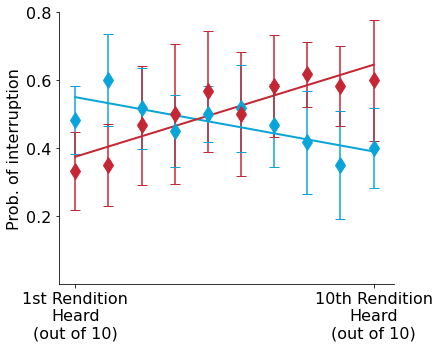

In [1124]:
fig = plt.figure(figsize=(6, 5))
rew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_song["kth Presentation"],
    rew_song["p(interrupt)"],
    yerr=2*rew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded")
)
norew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_song["kth Presentation"], 
    norew_song["p(interrupt)"],
    yerr=2*norew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded")
)

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_song["kth Presentation"], rew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_song["kth Presentation"], norew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Nonrewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4A_song_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)


fig = plt.figure(figsize=(6, 5))
rew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_dc["kth Presentation"],
    rew_dc["p(interrupt)"],
    yerr=2*rew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded"))
norew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_dc["kth Presentation"], 
    norew_dc["p(interrupt)"],
    yerr=2*norew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded"))

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_dc["kth Presentation"], rew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_dc["kth Presentation"], 
    lin(rew_dc["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_dc["kth Presentation"], norew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Nonrewarded", r_squared, r_adj))
plt.plot(
    norew_dc["kth Presentation"], 
    lin(norew_dc["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4B_dc_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)

In [1125]:
result = group_by_kth_presentation(non_ncm_trials_new)

Song Rewarded R2 = 0.09 R2_adj = -0.02
Song Nonrewarded R2 = 0.13 R2_adj = 0.02


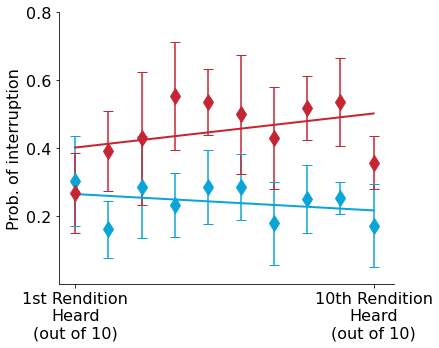

DC Rewarded R2 = 0.27 R2_adj = 0.18
DC Nonrewarded R2 = 0.72 R2_adj = 0.69


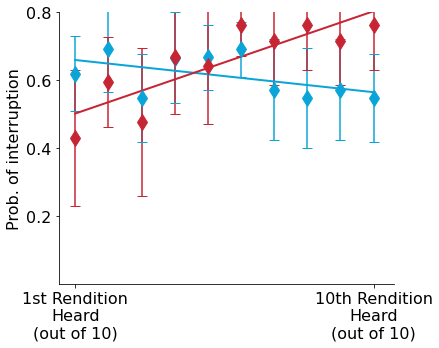

In [1128]:
fig = plt.figure(figsize=(6, 5))
rew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_song["kth Presentation"],
    rew_song["p(interrupt)"],
    yerr=2*rew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded")
)
norew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_song["kth Presentation"], 
    norew_song["p(interrupt)"],
    yerr=2*norew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded")
)

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_song["kth Presentation"], rew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_song["kth Presentation"], norew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Nonrewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4A_song_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)


fig = plt.figure(figsize=(6, 5))
rew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_dc["kth Presentation"],
    rew_dc["p(interrupt)"],
    yerr=2*rew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded"))
norew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_dc["kth Presentation"], 
    norew_dc["p(interrupt)"],
    yerr=2*norew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded"))

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_dc["kth Presentation"], rew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_dc["kth Presentation"], 
    lin(rew_dc["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_dc["kth Presentation"], norew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Nonrewarded", r_squared, r_adj))
plt.plot(
    norew_dc["kth Presentation"], 
    lin(norew_dc["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4B_dc_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)

In [1129]:
result = group_by_kth_presentation(non_ncm_trials_original)

Song Rewarded R2 = 0.03 R2_adj = -0.09
Song Nonrewarded R2 = 0.85 R2_adj = 0.83


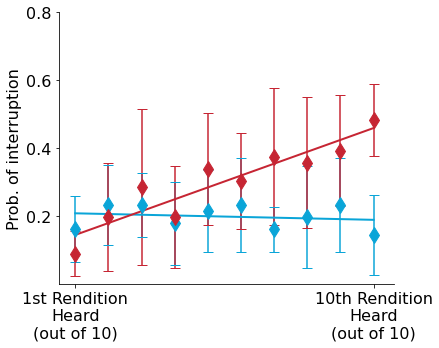

DC Rewarded R2 = 0.00 R2_adj = -0.12
DC Nonrewarded R2 = 0.34 R2_adj = 0.25


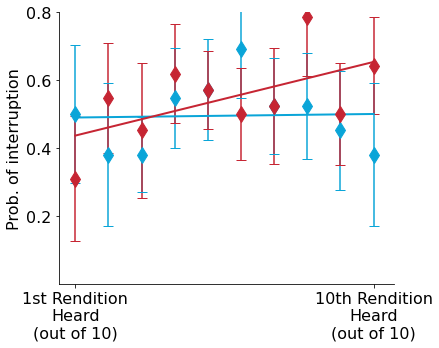

In [1130]:
fig = plt.figure(figsize=(6, 5))
rew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_song["kth Presentation"],
    rew_song["p(interrupt)"],
    yerr=2*rew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded")
)
norew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_song["kth Presentation"], 
    norew_song["p(interrupt)"],
    yerr=2*norew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded")
)

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_song["kth Presentation"], rew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_song["kth Presentation"], norew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Nonrewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4A_song_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)


fig = plt.figure(figsize=(6, 5))
rew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_dc["kth Presentation"],
    rew_dc["p(interrupt)"],
    yerr=2*rew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded"))
norew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_dc["kth Presentation"], 
    norew_dc["p(interrupt)"],
    yerr=2*norew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded"))

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_dc["kth Presentation"], rew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_dc["kth Presentation"], 
    lin(rew_dc["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_dc["kth Presentation"], norew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Nonrewarded", r_squared, r_adj))
plt.plot(
    norew_dc["kth Presentation"], 
    lin(norew_dc["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

# fig.savefig("figures/4B_dc_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)